In [2]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import os
from scipy.stats import pearsonr, spearmanr, fisher_exact, mannwhitneyu, ttest_ind

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd

from matplotlib.pyplot import rc_context
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.cm as cm

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
sys.path.append('../../../Code/')
from utils import read_dataset_log
import pickle as pkl
import matplotlib.gridspec as gridspec

In [3]:
from matplotlib import rcParams, font_manager

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
#rcParams['text.usetex'] = True

In [4]:
figdir = '../../../Figures/Components'

In [5]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,manual_gating_fn,manual_activation_gating_fn,activation_score_fn,metadata_fn,...,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label,tcat_fn_old
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Activa...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,...,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Ac...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,...,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...,/data/srlab1/TCAT/Data/PerDataset/TBRU/Activat...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,...,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Acti...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,...,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,...,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCA

In [6]:
gep_info = read_dataset_log('cGEP_Name')
rename_map = dict(zip(gep_info['cGep_Name'], gep_info['Short_Name']))
shorten_map = dict(zip(gep_info['Short_Name'], gep_info['Shortest_Name']))

In [7]:
lineage_geps = gep_info[gep_info['Class']=='Lineage']['Short_Name'].tolist()

In [8]:
cc_geps = ['CellCycle-G2M', 'CellCycle-S', 'CellCycle-Late-S']

In [9]:
activation_threshold = 0.0625

In [10]:
phenomap = {
    'COMBAT':{
        'phenocol':'Source',
        'mapping':{'COVID_SEV':'Covid-19', 'Sepsis':np.nan, 'COVID_MILD':'Covid-19', 'COVID_HCW_MILD':'Covid-19', 'HV':'Healthy',
                  'COVID_CRIT':'Covid-19', 'COVID_LDN':'Covid-19', 'Flu':np.nan},
        'allcols':['Source', 'TimeSinceOnset']
    },
    
    'UK-Covid':{
        'phenocol':'Status_on_day_collection_summary',
        'mapping':{'Moderate':'Covid-19', 'Mild':'Covid-19', 'Critical':'Covid-19', 'Severe':'Covid-19', 'Healthy':'Healthy', 'Asymptomatic':np.nan,
                  'Non_covid':np.nan, 'LPS_90mins':np.nan, 'LPS_10hours':np.nan},
        'allcols':['Status_on_day_collection_summary', 'Days_from_onset']
        
    },
    
    'Sparks':{
        'phenocol':'visit',
        'mapping':{'Day 0':'D0', 'Day 1':'D1', 'Day 28':'D28', np.nan:'Control'},
        'allcols':['visit', 'group', 'vaccine']
    },
        
        
    'HIV-Vaccine':{
        'phenocol':'time',
        'mapping':{'0':'D0', '3':'D3', '7':'D7'},
        'allcols':['time'] 
        
    },    

    
    'Pan-Cancer':{
        'phenocol':'loc',
        'mapping':{'T':'Cancer', 'N':'Normal'},
        'allcols':['loc', 'cancerType', 'meta.cluster'] 
        
    },    
    
    
}

In [11]:
cd4_convs = ['CD4_Naive', 'CD4_CM', 'CD4_EM', 'CD4_TEMRA', 'CD4_Memory']

cd8_convs = [ 'CD8_TEMRA', 'CD8_EM', 'CD8_Naive', 'CD8_CM']

regs = ['Treg']
unconv = ['gdT', 'MAIT', 'DN']
mapping = dict(zip(cd4_convs + cd8_convs + regs + unconv, ['CD4 conv']*len(cd4_convs) + ['CD8 conv']*len(cd8_convs) + ['Treg']*len(regs) + ['unconv']*len(unconv)))
mapping

{'CD4_Naive': 'CD4 conv',
 'CD4_CM': 'CD4 conv',
 'CD4_EM': 'CD4 conv',
 'CD4_TEMRA': 'CD4 conv',
 'CD4_Memory': 'CD4 conv',
 'CD8_TEMRA': 'CD8 conv',
 'CD8_EM': 'CD8 conv',
 'CD8_Naive': 'CD8 conv',
 'CD8_CM': 'CD8 conv',
 'Treg': 'Treg',
 'gdT': 'unconv',
 'MAIT': 'unconv',
 'DN': 'unconv'}

# Load

In [ ]:
actinfo = {}

for dataset in ['Pan-Cancer', 'HIV-Vaccine', 'Sparks','COMBAT', 'UK-Covid']:
    individual_col = params.loc[dataset, 'individual_col']
    sample_col = params.loc[dataset, 'sample_col']
    count_fn = params.loc[dataset, 'raw_counts_filt_fn']
    adata = sc.read(count_fn)
    
    if dataset == 'Sparks':
        adata.obs[sample_col] = adata.obs['alt.subject.id'].astype(str) + adata.obs['visit'].astype(str).replace({'nan':'', 'Day 0':'.D0', 'Day 1':'.D1', 'Day 28':'.D28'})
    
    usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')
    usage.columns = usage.columns.map(rename_map)
    usage_norm = usage.div(usage.sum(axis=1), axis=0)
    
    activation = pd.read_csv(params.loc[dataset, 'activation_score_fn'], index_col = 0, sep = '\t')
    activation_score = activation['Activation_Score']
    activation['Activation_Status'] = activation['Activation_Score'] > activation_threshold
    activation = pd.merge(left=activation, right=adata.obs[[individual_col, sample_col] + phenomap[dataset]['allcols']],
                          how='left', left_index=True, right_index=True)
    
    activation.rename(columns={individual_col:'individual', sample_col:'sample'}, inplace=True)
    
    activation['CellCycle_Usage'] = usage_norm.loc[activation.index, cc_geps].sum(axis=1)
    activation['Exhaustion_Usage'] = usage_norm.loc[activation.index, 'Exhaustion']
    activation['CellCycle_Bin'] = activation['CellCycle_Usage']>activation_threshold
    activation['Exhaustion_Bin'] = activation['Exhaustion_Usage']>activation_threshold
    
    if dataset not in ['Pan-Cancer']:
        gating = pd.read_csv(params.loc[dataset, 'manual_gating_fn'], sep='\t', index_col=0)['0']
        activation['Gating'] = gating.loc[activation.index]
        activation['Gating_Simple'] = activation['Gating'].replace(mapping)
        
    activation['Pheno'] = activation[phenomap[dataset]['phenocol']].replace(phenomap[dataset]['mapping'])
    activation['Dataset'] = dataset
    actinfo[dataset] = activation

In [ ]:
with open('../../../Data/TCAT/Activation_Scores_Phenotypes_AllDatasets.pkl', 'wb') as file:
    pkl.dump(actinfo, file)

# Filter duplicates for some datasets

In [12]:
with open('../../../Data/TCAT/Activation_Scores_Phenotypes_AllDatasets.pkl', 'rb') as file:
    actinfo = pkl.load(file)

In [13]:
actinfo['Pan-Cancer']['orig.individual'] = actinfo['Pan-Cancer']['individual']
actinfo['Pan-Cancer']['individual'] = actinfo['Pan-Cancer']['individual'].astype(str) + '.' + actinfo['Pan-Cancer']['loc'].astype(str)

In [14]:
actinfo_filt = {}
for dataset in ['Pan-Cancer', 'COMBAT', 'UK-Covid']:
    activation = actinfo[dataset].copy()
    ct = pd.crosstab(activation['individual'], activation['sample'])    
    display((ct>0).sum(axis=1).value_counts())
    ind = (ct>0).sum(axis=1)>1
    ct = ct.loc[ind, :]
    tokeep = ct.loc[:, (ct>0).sum(axis=0)>0].idxmax(axis=1)

    tofilt = activation['individual'].isin(tokeep.index) & ~activation['sample'].isin(tokeep.values)
    activation_filt = activation.loc[~tofilt, :]
    ct = pd.crosstab(activation_filt['individual'], activation_filt['sample'])
    display((ct>0).sum(axis=1).value_counts())
    actinfo_filt[dataset] = activation_filt

1    113
2     12
4      7
3      4
dtype: int64

1    136
dtype: int64

1    109
2     10
3      3
dtype: int64

1    122
dtype: int64

1    109
2     12
dtype: int64

1    121
dtype: int64

# Pan-cancer

In [15]:
final_category = {'CD8.Tm':'CD8 Conv',
 'CD8.Tem':'CD8 Conv',
 'CD8.Trm':'CD8 Conv',
 'CD8.Tex':'CD8 Conv',
 'CD8.Temra':'CD8 Conv',
 'CD8.Tn':'CD8 Conv',
 'CD8.MAIT':'CD8 Conv',
 'CD8.Tk':'CD8 Conv',
 'CD8.ISG':'CD8 Conv',

 'CD4.Treg':'CD4 Treg',

 'CD4.Tm':'CD4 Conv',
 'CD4.Tn':'CD4 Conv',
 
 
 'CD4.Tfh':'CD4 Conv',
 'CD4.Th17':'CD4 Conv',
 'CD4.Tem':'CD4 Conv',
 'CD4.Temra':'CD4 Conv',
 'CD4.TfhTh1':'CD4 Conv',
 'CD4.Mix':'CD4 Conv',
 'CD4.ISG':'CD4 Conv'}

actinfo_filt['Pan-Cancer']['meta.cluster.short'] = actinfo_filt['Pan-Cancer']['meta.cluster'].apply(lambda x: '.'.join(np.array(x.split('.'))[[0, 2]]))
actinfo_filt['Pan-Cancer']['lineage'] = actinfo_filt['Pan-Cancer']['meta.cluster.short'].replace(final_category)

In [16]:
actinfo['Pan-Cancer']['cancerType'].value_counts()

THCA    56956
UCEC    32652
RC      31176
ESCA    24882
BCC     21011
PACA    11504
HCC     10964
MM       8279
BC       7354
OV       4522
BCL      3493
LUNG     1205
FTC      1037
Name: cancerType, dtype: int64

In [17]:
actinfo_filt['Pan-Cancer']['cancerType'].value_counts()

THCA    56956
UCEC    32652
RC      28621
ESCA    24882
BCC     14346
PACA    11504
HCC      8964
MM       8279
BC       7354
OV       4522
BCL      3493
LUNG     1205
FTC      1037
Name: cancerType, dtype: int64

In [18]:
X = actinfo_filt['Pan-Cancer']
pd.crosstab(X.loc[X['cancerType']=='LUNG', 'individual'], X.loc[X['cancerType']=='LUNG', 'loc'])

loc,N,T
individual,,
NSCLC.QianqianSong2019.P1.N,407,0
NSCLC.QianqianSong2019.P1.T,0,170
NSCLC.QianqianSong2019.P2.N,10,0
NSCLC.QianqianSong2019.P2.T,0,17
NSCLC.QianqianSong2019.P3.N,50,0
NSCLC.QianqianSong2019.P4.N,551,0


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()


Text(0.5, 1.0, 'CD4 Conv')

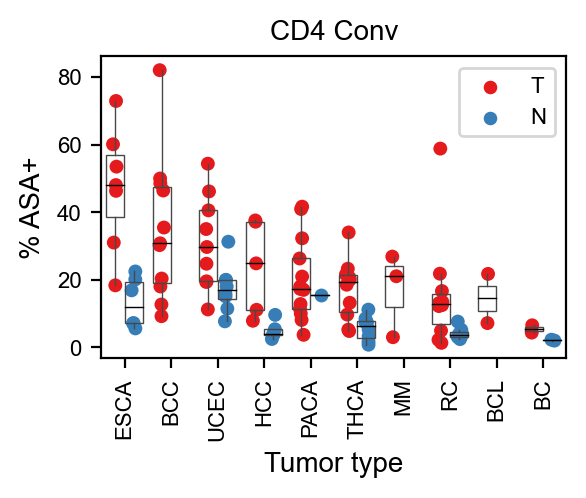

In [19]:
mincells = 20
mintumors = 2
dat = actinfo_filt['Pan-Cancer']
lineage = 'CD4 Conv'
readout = 'Activation_Status'



ind = (dat['lineage'] == lineage)
dat = dat.loc[ind, :]
dat[['individual', 'loc', 'cancerType']] = dat[['individual', 'loc', 'cancerType']].astype(str)
sample_stats = dat.groupby(['individual', 'loc', 'cancerType']).count()[readout].reset_index().rename(columns={'Activation_Status':'Ncell'})
num_tumors = sample_stats.loc[(sample_stats['Ncell']>=mincells) & (sample_stats['loc']=='T'), 'cancerType'].value_counts()
tumors_to_filt = num_tumors.index[num_tumors<mintumors]
dat = dat.loc[~dat['cancerType'].isin(tumors_to_filt), :]

sample_average = (dat.groupby(['individual', 'loc', 'cancerType'])['CellCycle_Bin', 'Activation_Status', 'Exhaustion_Bin'].mean()*100).dropna().reset_index()
sample_average = pd.merge(left=sample_average, right=sample_stats[['individual', 'Ncell']], on='individual', how='left')
sample_average = sample_average.loc[sample_average['Ncell']>=mincells, :]
order = list(sample_average.loc[sample_average['loc'] == 'T', :].groupby('cancerType')[readout].mean().sort_values(ascending=False).index)

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200)
sp = sns.stripplot(x='cancerType', y='Activation_Status', hue='loc', dodge=True, data=sample_average, order=order, hue_order=['T', 'N'], palette="Set1", ax=ax,
              zorder=-1)
sns.boxplot(x='cancerType', y=readout, data=sample_average, hue='loc', order=order, hue_order=['T', 'N'], palette="Set1", ax=ax,
            dodge=True, fliersize=0, showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, zorder=5)

handles, labels = sp.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(1,1), handles=handles[:2], labels=labels[:2], fontsize=8, markerscale=.5)


ax.set_xticklabels(order, rotation=90)
ax.tick_params(labelsize=8)
ax.set_xlabel('Tumor type', fontsize=10)
ax.set_ylabel('% ASA+', fontsize=10)
ax.set_title(lineage, fontsize=10)

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()


Text(0.5, 1.0, 'CD4 Conv')

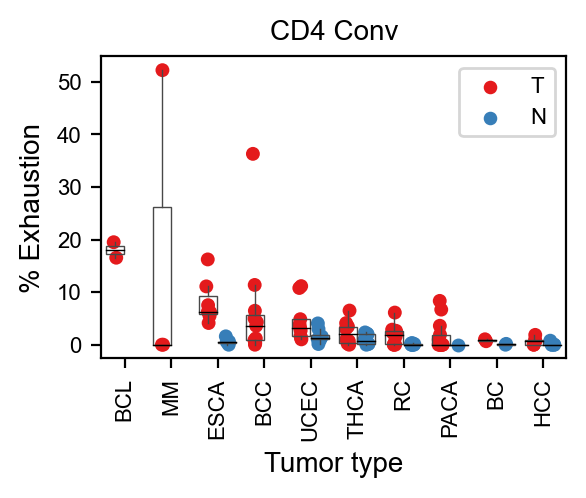

In [20]:
mincells = 20
mintumors = 2
dat = actinfo_filt['Pan-Cancer']
lineage = 'CD4 Conv'
readout = 'Exhaustion_Bin'



ind = (dat['lineage'] == lineage)
dat = dat.loc[ind, :]
dat[['individual', 'loc', 'cancerType']] = dat[['individual', 'loc', 'cancerType']].astype(str)
sample_stats = dat.groupby(['individual', 'loc', 'cancerType']).count()['Activation_Status'].reset_index().rename(columns={'Activation_Status':'Ncell'})
num_tumors = sample_stats.loc[(sample_stats['Ncell']>=mincells) & (sample_stats['loc']=='T'), 'cancerType'].value_counts()
tumors_to_filt = num_tumors.index[num_tumors<mintumors]
dat = dat.loc[~dat['cancerType'].isin(tumors_to_filt), :]

sample_average = (dat.groupby(['individual', 'loc', 'cancerType'])['CellCycle_Bin', 'Activation_Status', 'Exhaustion_Bin'].mean()*100).dropna().reset_index()
sample_average = pd.merge(left=sample_average, right=sample_stats[['individual', 'Ncell']], on='individual', how='left')
sample_average = sample_average.loc[sample_average['Ncell']>=mincells, :]
order = list(sample_average.loc[sample_average['loc'] == 'T', :].groupby('cancerType')[readout].mean().sort_values(ascending=False).index)

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200)
sp = sns.stripplot(x='cancerType', y=readout, hue='loc', dodge=True, data=sample_average, order=order, hue_order=['T', 'N'], palette="Set1", ax=ax,
              zorder=-1)
sns.boxplot(x='cancerType', y=readout, data=sample_average, hue='loc', order=order, hue_order=['T', 'N'], palette="Set1", ax=ax,
            dodge=True, fliersize=0, showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, zorder=5)

handles, labels = sp.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(1,1), handles=handles[:2], labels=labels[:2], fontsize=8, markerscale=.5)


ax.set_xticklabels(order, rotation=90)
ax.tick_params(labelsize=8)
ax.set_xlabel('Tumor type', fontsize=10)
ax.set_ylabel('% Exhaustion', fontsize=10)
ax.set_title(lineage, fontsize=10)

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


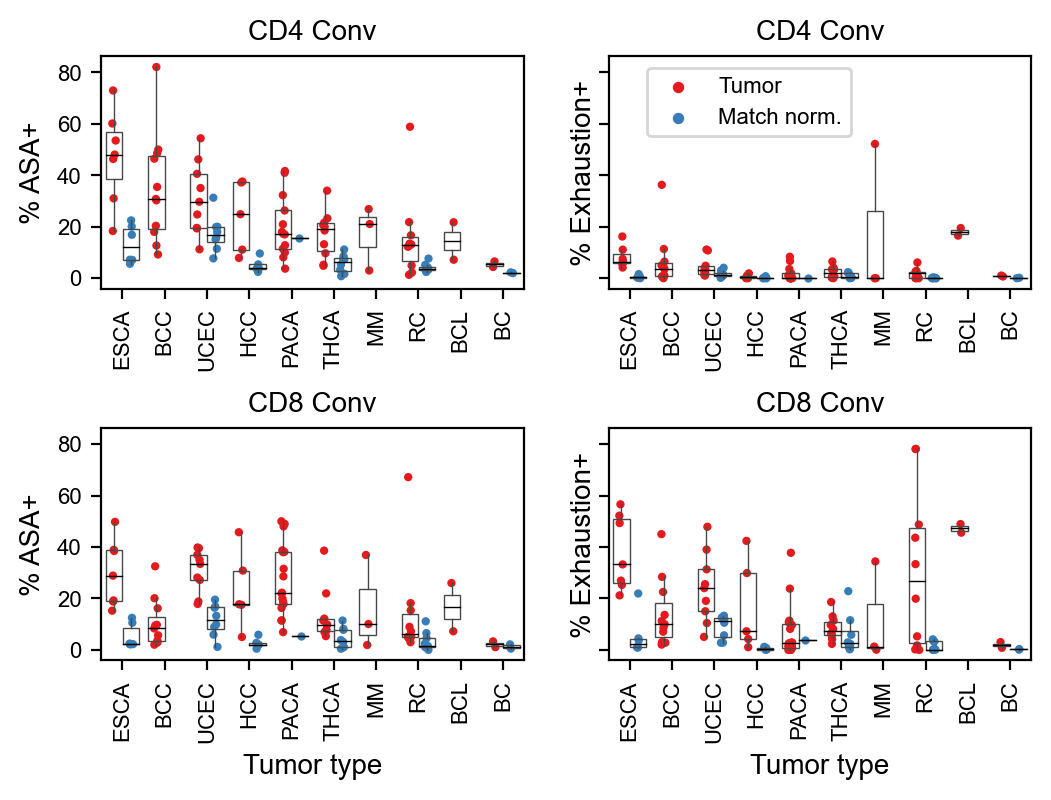

In [21]:
mincells = 20
mintumors = 2

(fig, axes) = plt.subplots(2,2, figsize=(6,4), dpi=200, gridspec_kw={'hspace':.6}, sharey=True)
count = 0 

for i,readout in enumerate(['Activation_Status', 'Exhaustion_Bin']):
    for j,lineage in enumerate(['CD4 Conv', 'CD8 Conv']):
        dat = actinfo_filt['Pan-Cancer'].copy()
        dat['Pheno2'] = dat['Pheno'].replace({'Cancer':'Tumor', 'Normal':'Match norm.'})
        
        
        ind = (dat['lineage'] == lineage)
        dat = dat.loc[ind, :]
        dat[['individual', 'Pheno2', 'cancerType']] = dat[['individual', 'Pheno2', 'cancerType']].astype(str)
        sample_stats = dat.groupby(['individual', 'Pheno2', 'cancerType']).count()['Activation_Status'].reset_index().rename(columns={'Activation_Status':'Ncell'})
        num_tumors = sample_stats.loc[(sample_stats['Ncell']>=mincells) & (sample_stats['Pheno2']=='Tumor'), 'cancerType'].value_counts()
        tumors_to_filt = num_tumors.index[num_tumors<mintumors]
        dat = dat.loc[~dat['cancerType'].isin(tumors_to_filt), :]

        sample_average = (dat.groupby(['individual', 'Pheno2', 'cancerType'])['CellCycle_Bin', 'Activation_Status', 'Exhaustion_Bin'].mean()*100).dropna().reset_index()
        sample_average = pd.merge(left=sample_average, right=sample_stats[['individual', 'Ncell']], on='individual', how='left')
        sample_average = sample_average.loc[sample_average['Ncell']>=mincells, :]
        
        if count == 0:
            order = list(sample_average.loc[sample_average['Pheno2'] == 'Tumor', :].groupby('cancerType')[readout].mean().sort_values(ascending=False).index)

        ax = axes[j, i]
        sp = sns.stripplot(x='cancerType', y=readout, hue='Pheno2', dodge=True, data=sample_average, order=order, hue_order=['Tumor', 'Match norm.'],
                           palette="Set1", ax=ax, zorder=-1, s=3)
        sns.boxplot(x='cancerType', y=readout, data=sample_average, hue='Pheno2', order=order, hue_order=['Tumor', 'Match norm.'], palette="Set1", ax=ax,
            dodge=True, fliersize=0, showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, zorder=5)

        ax.set_xticklabels(order, rotation=90)
        ax.tick_params(labelsize=8)
        
        if j == 1:
            ax.set_xlabel('Tumor type', fontsize=10)
        else:
            ax.set_xlabel('', fontsize=10)
        
        if readout == 'Exhaustion_Bin':
            ax.set_ylabel('% Exhaustion+', fontsize=10)
        else:
            ax.set_ylabel('% ASA+', fontsize=10)
            
        if (i==1) and (j == 0):
            handles, labels = sp.get_legend_handles_labels()
            ax.legend(bbox_to_anchor=(0.6,1), handles=handles[:2], labels=labels[:2], fontsize=8, markerscale=.4)
        else:
            ax.legend_.remove()
                


        ax.set_title(lineage, fontsize=10)
        count += 1

        



In [22]:
actinfo_filt['Pan-Cancer']['Bystander_Bin'] = actinfo_filt['Pan-Cancer']['Exhaustion_Usage'] + actinfo_filt['Pan-Cancer']['Activation_Score'] < activation_threshold

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: 

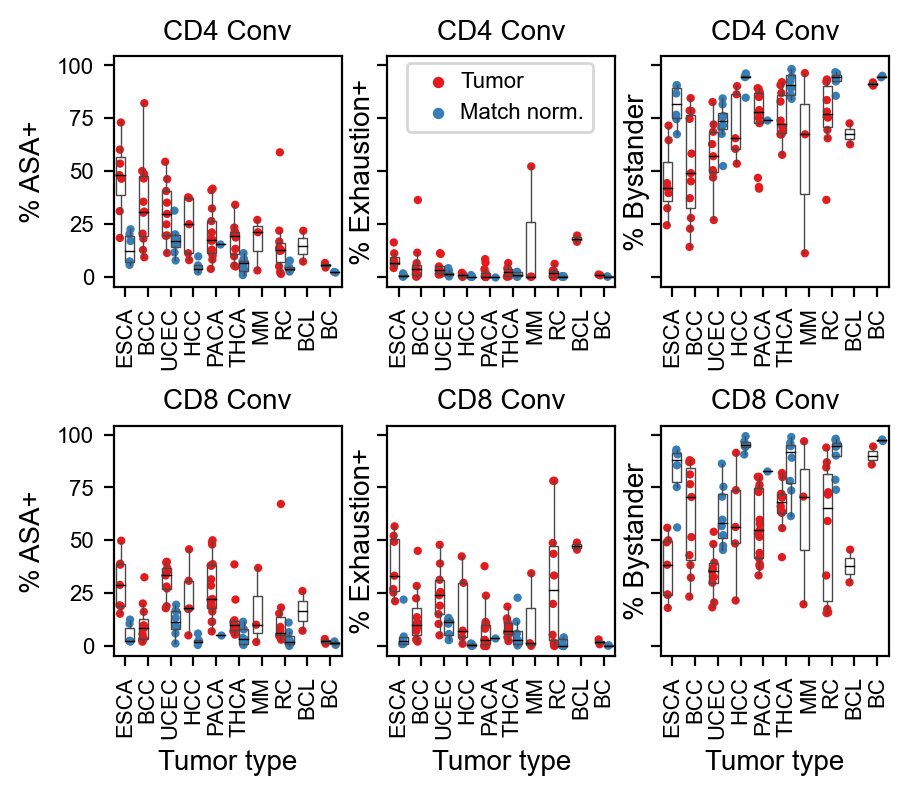

In [23]:
mincells = 20
mintumors = 2
minnormals = 0


(fig, axes) = plt.subplots(2,3, figsize=(5,4), dpi=200, gridspec_kw={'hspace':.6, 'top':.9, 'bottom':.15}, sharey=True)
count = 0 
allres = {}


for i,readout in enumerate(['Activation_Status', 'Exhaustion_Bin', 'Bystander_Bin']):
    for j,lineage in enumerate(['CD4 Conv', 'CD8 Conv']):
        dat = actinfo_filt['Pan-Cancer'].copy()
        dat['Pheno2'] = dat['Pheno'].replace({'Cancer':'Tumor', 'Normal':'Match norm.'})
        
        
        ind = (dat['lineage'] == lineage)
        dat = dat.loc[ind, :]
        dat[['individual', 'Pheno2']] = dat[['individual', 'Pheno2']].astype(str)
        sample_stats = dat.groupby(['individual', 'Pheno2', 'cancerType']).count()['Activation_Status'].reset_index().rename(columns={'Activation_Status':'Ncell'})
        num_tumors = sample_stats.loc[(sample_stats['Ncell']>=mincells) & (sample_stats['Pheno2']=='Tumor'), 'cancerType'].value_counts()
        num_normals = sample_stats.loc[(sample_stats['Ncell']>=mincells) & (sample_stats['Pheno2']=='Match norm.'), 'cancerType'].value_counts()
        tumors_to_filt = list(set(num_tumors.index[num_tumors<mintumors]).union(set(num_normals.index[num_normals<minnormals])))        
        dat = dat.loc[~dat['cancerType'].isin(tumors_to_filt), :]

        
        dat[['cancerType']] = dat[['cancerType']].astype(str)
        sample_average = (dat.groupby(['individual', 'Pheno2', 'cancerType'])['CellCycle_Bin', 'Activation_Status', 'Exhaustion_Bin', 'Bystander_Bin'].mean()*100).dropna().reset_index()
        sample_average = pd.merge(left=sample_average, right=sample_stats[['individual', 'Ncell']], on='individual', how='left')
        sample_average = sample_average.loc[sample_average['Ncell']>=mincells, :]
        
        if count == 0:
            order = list(sample_average.loc[sample_average['Pheno2'] == 'Tumor', :].groupby('cancerType')[readout].mean().sort_values(ascending=False).index)

        ax = axes[j, i]
        sp = sns.stripplot(x='cancerType', y=readout, hue='Pheno2', dodge=True, data=sample_average, order=order, hue_order=['Tumor', 'Match norm.'],
                           palette="Set1", ax=ax, zorder=-1, s=3)
        sns.boxplot(x='cancerType', y=readout, data=sample_average, hue='Pheno2', order=order, hue_order=['Tumor', 'Match norm.'], palette="Set1", ax=ax,
            dodge=True, fliersize=0, showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, zorder=5)


        ax.set_xticklabels(order, rotation=90)
        ax.tick_params(labelsize=8)
        
        if readout == 'Activation_Status':
            allres[lineage] = sample_average
        
        if j == 1:
            ax.set_xlabel('Tumor type', fontsize=10)
        else:
            ax.set_xlabel('', fontsize=10)
        
        if readout == 'Exhaustion_Bin':
            ax.set_ylabel('% Exhaustion+', fontsize=10)
        elif readout == 'Bystander_Bin':
            ax.set_ylabel('% Bystander', fontsize=10)
            
        else:
            ax.set_ylabel('% ASA+', fontsize=10)
            
        if (i==1) and (j == 0):
            handles, labels = sp.get_legend_handles_labels()
            ax.legend(bbox_to_anchor=(.95,1.02), handles=handles[:2], labels=labels[:2], fontsize=8, markerscale=.4, handletextpad=0)
        else:
            ax.legend_.remove()
                


        ax.set_title(lineage, fontsize=10)
        count += 1

plt.savefig(os.path.join(figdir, 'CancerVsActivationExhaustionBystander.Stripplot.png'))
plt.savefig(os.path.join(figdir, 'CancerVsActivationExhaustionBystander.Stripplot.pdf'))

In [24]:
allres['CD4 Conv'].groupby(['cancerType', 'Pheno2']).median()['Exhaustion_Bin']

cancerType  Pheno2     
BC          Match norm.     0.080645
            Tumor           0.848502
BCC         Tumor           3.600823
BCL         Tumor          18.014965
ESCA        Match norm.     0.464295
            Tumor           6.293706
HCC         Match norm.     0.000000
            Tumor           0.636943
MM          Tumor           0.000000
PACA        Match norm.     0.000000
            Tumor           0.000000
RC          Match norm.     0.000000
            Tumor           1.835284
THCA        Match norm.     0.642771
            Tumor           2.036575
UCEC        Match norm.     1.302597
            Tumor           3.201220
Name: Exhaustion_Bin, dtype: float64

In [25]:
allres['CD4 Conv'].groupby(['cancerType', 'Pheno2']).median()['Bystander_Bin'].sort_values()

cancerType  Pheno2     
ESCA        Tumor          41.959335
BCC         Tumor          49.003984
UCEC        Tumor          57.017544
HCC         Tumor          65.508021
MM          Tumor          67.368421
BCL         Tumor          67.601754
THCA        Tumor          72.470087
UCEC        Match norm.    73.463916
PACA        Match norm.    74.025974
RC          Tumor          76.932740
PACA        Tumor          77.777778
ESCA        Match norm.    81.666119
THCA        Match norm.    90.893750
BC          Tumor          91.199004
RC          Match norm.    94.397473
HCC         Match norm.    94.642857
BC          Match norm.    94.702172
Name: Bystander_Bin, dtype: float64

In [26]:
allres['CD8 Conv'].groupby(['cancerType', 'Pheno2']).median()['Bystander_Bin'].sort_values()

cancerType  Pheno2     
UCEC        Tumor          35.536723
BCL         Tumor          37.806973
ESCA        Tumor          38.411669
PACA        Tumor          54.761905
HCC         Tumor          56.300268
UCEC        Match norm.    58.219985
RC          Tumor          65.359068
THCA        Tumor          68.127556
BCC         Tumor          70.482866
MM          Tumor          70.664024
PACA        Match norm.    82.701422
ESCA        Match norm.    88.041778
BC          Tumor          90.102064
THCA        Match norm.    91.806346
RC          Match norm.    94.653706
HCC         Match norm.    94.977169
BC          Match norm.    97.306456
Name: Bystander_Bin, dtype: float64

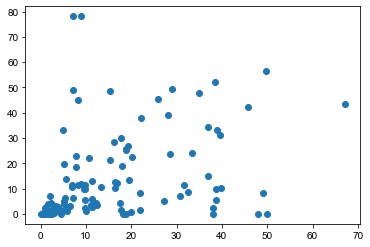

In [27]:
plt.scatter(allres['CD8 Conv']['Activation_Status'], allres['CD8 Conv']['Exhaustion_Bin'])

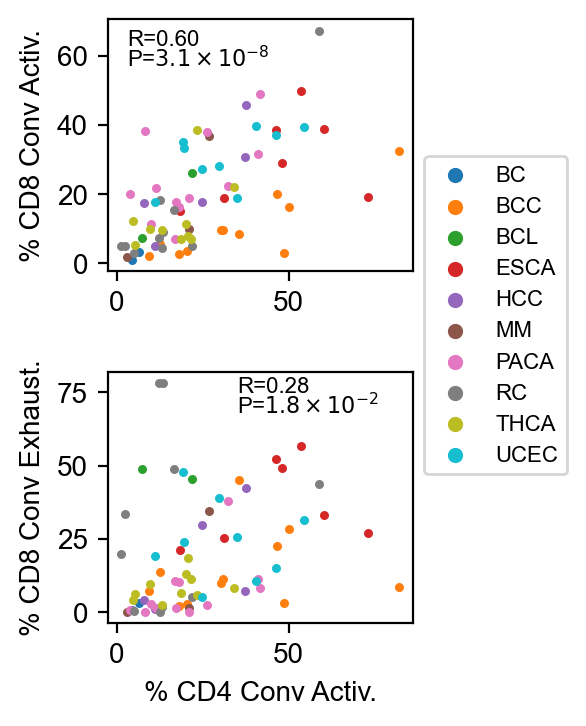

In [28]:
fig = plt.figure(figsize=(3, 4), dpi=200)
gs = gridspec.GridSpec(2, 2, width_ratios=[2, .5], left=.2, hspace=.4)
ax1 = fig.add_subplot(gs[0, 0]) # First row, first column
ax2 = fig.add_subplot(gs[1, 0]) # Second row, first column
legax = fig.add_subplot(gs[:, 1], frameon=False, xticks=[], yticks=[]) # Both rows, second column



X = pd.Series(allres['CD4 Conv']['Activation_Status'].values, index=allres['CD4 Conv']['individual'])
Y = pd.Series(allres['CD8 Conv']['Activation_Status'].values, index=allres['CD8 Conv']['individual'])
Z = pd.Series(allres['CD8 Conv']['Exhaustion_Bin'].values, index=allres['CD8 Conv']['individual'])


overlap = list(set(X.index).intersection(Y.index))

lab = allres['CD4 Conv'].copy()
lab.index = lab['individual']
lab = lab.loc[overlap, :]
lab['label'] = lab['cancerType'] #+ ' ' + Z['Pheno2'].replace('Match norm.', 'Norm')
data = pd.concat([X.loc[overlap], Y.loc[overlap], Z.loc[overlap], lab['label'],  lab['Pheno2']], axis=1)
data = data.loc[data['Pheno2']=='Tumor', :]
data.columns = ['CD4_Activation', 'CD8_Activation', 'CD8_Exhaustion', 'Cancer', 'Pheno']


pal = sns.color_palette()
palette = dict(zip(sorted(data['Cancer'].unique()), pal))


for (k,g) in data.groupby('Cancer'):
    ax1.scatter(g['CD4_Activation'], g['CD8_Activation'], label=k, color=palette[k], s=5)
    ax2.scatter(g['CD4_Activation'], g['CD8_Exhaustion'], label=k, color=palette[k], s=5)
    
    
ax1.legend(bbox_to_anchor=(1,.5), fontsize=8, markerscale=2)
ax2.set_xlabel('% CD4 Conv Activ.', fontsize=10)
ax1.set_ylabel('% CD8 Conv Activ.', fontsize=10)
ax2.set_ylabel('% CD8 Conv Exhaust.', fontsize=10)
    
R,P = pearsonr(data['CD4_Activation'], data['CD8_Activation'])  
P_sci_notation = f"{P:.1e}"
base, exponent = P_sci_notation.split("e")
exponent = int(exponent)  # Convert exponent to integer for clean formatting
ax1.text(3, 63, 'R=%.2f' %R, fontsize=8)
ax1.text(3, 57, r'P=${:.1f} \times 10^{{{}}}$'.format(float(base), exponent), fontsize=8)

R,P = pearsonr(data['CD4_Activation'], data['CD8_Exhaustion'])  
P_sci_notation = f"{P:.1e}"
base, exponent = P_sci_notation.split("e")
exponent = int(exponent)  # Convert exponent to integer for clean formatting
ax2.text(35, 75, 'R=%.2f' %R, fontsize=8)
ax2.text(35, 68, r'P=${:.1f} \times 10^{{{}}}$'.format(float(base), exponent), fontsize=8)

plt.savefig(os.path.join(figdir, 'CancerActivation.CD4vsCD8.Scatter.png'))
plt.savefig(os.path.join(figdir, 'CancerActivation.CD4vsCD8.Scatter.pdf'))


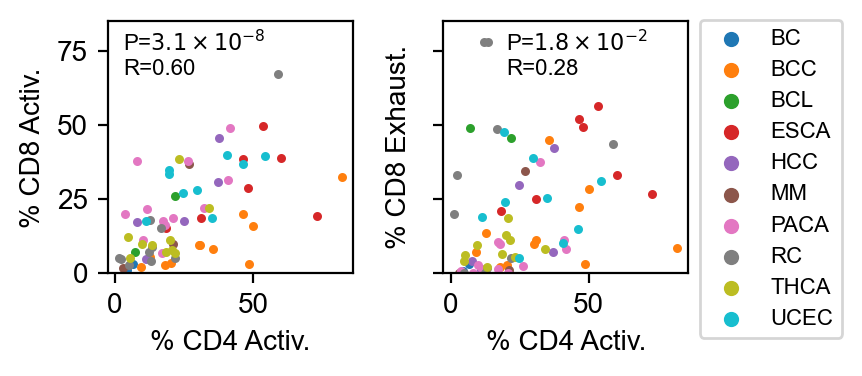

In [29]:
fig = plt.figure(figsize=(4.5, 2.0), dpi=200)
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 2, .4], left=.15, right=.95, bottom=.25, wspace=0.5)
ax1 = fig.add_subplot(gs[0]) # First row, first column
ax2 = fig.add_subplot(gs[1]) # Second row, first column
legax = fig.add_subplot(gs[2], frameon=False, xticks=[], yticks=[]) # Both rows, second column



X = pd.Series(allres['CD4 Conv']['Activation_Status'].values, index=allres['CD4 Conv']['individual'])
Y = pd.Series(allres['CD8 Conv']['Activation_Status'].values, index=allres['CD8 Conv']['individual'])
Z = pd.Series(allres['CD8 Conv']['Exhaustion_Bin'].values, index=allres['CD8 Conv']['individual'])


overlap = list(set(X.index).intersection(Y.index))

lab = allres['CD4 Conv'].copy()
lab.index = lab['individual']
lab = lab.loc[overlap, :]
lab['label'] = lab['cancerType'] #+ ' ' + Z['Pheno2'].replace('Match norm.', 'Norm')
data = pd.concat([X.loc[overlap], Y.loc[overlap], Z.loc[overlap], lab['label'],  lab['Pheno2']], axis=1)
data = data.loc[data['Pheno2']=='Tumor', :]
data.columns = ['CD4_Activation', 'CD8_Activation', 'CD8_Exhaustion', 'Cancer', 'Pheno']


pal = sns.color_palette()
palette = dict(zip(sorted(data['Cancer'].unique()), pal))


for (k,g) in data.groupby('Cancer'):
    ax1.scatter(g['CD4_Activation'], g['CD8_Activation'], label=k, color=palette[k], s=5)
    ax2.scatter(g['CD4_Activation'], g['CD8_Exhaustion'], label=k, color=palette[k], s=5)
    
   
ax2.legend(bbox_to_anchor=(1,1.05), fontsize=8, markerscale=2)
ax1.set_xlabel('% CD4 Activ.', fontsize=10)
ax2.set_xlabel('% CD4 Activ.', fontsize=10)
ax1.set_ylabel('% CD8 Activ.', fontsize=10)
ax2.set_ylabel('% CD8 Exhaust.', fontsize=10)
ax2.set_yticklabels([])
   
R,P = pearsonr(data['CD4_Activation'], data['CD8_Activation'])  
P_sci_notation = f"{P:.1e}"
base, exponent = P_sci_notation.split("e")
exponent = int(exponent)  # Convert exponent to integer for clean formatting
ax1.text(3, 75, r'P=${:.1f} \times 10^{{{}}}$'.format(float(base), exponent), fontsize=8)
ax1.text(3, 67, 'R=%.2f' %R, fontsize=8)

R,P = pearsonr(data['CD4_Activation'], data['CD8_Exhaustion'])  
P_sci_notation = f"{P:.1e}"
base, exponent = P_sci_notation.split("e")
exponent = int(exponent)  # Convert exponent to integer for clean formatting
ax2.text(20, 75, r'P=${:.1f} \times 10^{{{}}}$'.format(float(base), exponent), fontsize=8)
ax2.text(20, 67, 'R=%.2f' %R, fontsize=8)

ax1.set_ylim([0, 85])
ax2.set_ylim([0, 85])

plt.savefig(os.path.join(figdir, 'CancerActivation.CD4vsCD8.Scatter.Horizontal.png'))
plt.savefig(os.path.join(figdir, 'CancerActivation.CD4vsCD8.Scatter.Horizontal.pdf'))


In [30]:
usage = pd.read_csv(params.loc['Pan-Cancer', 'tcat_fn'], sep='\t', index_col=0).rename(columns=rename_map)
usage_norm = usage.div(usage.sum(axis=1), axis=0)

In [31]:
max_identity = usage_norm[lineage_geps].idxmax(axis=1)
max_identity_usage = usage_norm[lineage_geps].max(axis=1)

In [32]:
max_identity_filt = max_identity.loc[(max_identity_usage>.1)]
max_identity_filt.head()

bcc.su001.pre.tcell_AAAGCAAAGCAGGTCA-0       CD4-CM
bcc.su001.pre.tcell_AAAGTAGGTATATGAG-0         Treg
bcc.su001.pre.tcell_AAATGCCAGACTGTAA-0    CD4-Naive
bcc.su001.pre.tcell_AAATGCCTCCTCTAGC-0         Treg
bcc.su001.pre.tcell_AACCGCGAGGTGTTAA-0         Treg
dtype: object

In [33]:
overlap = sorted(set(actinfo_filt['Pan-Cancer'].index).intersection(max_identity_filt.index))
dat = pd.concat([max_identity_filt.loc[overlap], actinfo_filt['Pan-Cancer'].loc[overlap, ['Bystander_Bin', 'Activation_Status', 'loc', 'cancerType']]], axis=1)

In [34]:
dat2 = dat.loc[dat['loc']=='T', :]
dat2.head()

,0,Bystander_Bin,Activation_Status,loc,cancerType
4602STDY6795900___ACCTTTAGTAAATACG-22,MAIT,True,False,T,RC
4602STDY6795900___ACGCAGCGTCAGTGGA-22,MAIT,True,False,T,RC
4602STDY6795900___ACTGAACGTCTTGTCC-23,MAIT,True,False,T,RC
4602STDY6795900___AGGGTGAGTTCCGGCA-22,Th17-Resting,True,False,T,RC
4602STDY6795900___ATAACGCTCCCTCAGT-23,Th1-Like,True,False,T,RC


In [35]:
res = []
for lin in dat2[0].unique():
    ct = pd.crosstab((dat2[0]==lin).astype(str), dat2['Bystander_Bin'].astype(str))
    ct = ct.loc[['False', 'True'], ['False', 'True']]
    OR, P = fisher_exact(ct)
    logOR = np.log(OR)
    se_log_or = np.sqrt((1 / ct).sum().sum())  
    ci_low_or = np.exp(logOR - 1.96*se_log_or)
    ci_high_or = np.exp(logOR + 1.96*se_log_or)    
    log2OR = np.log2(OR)
    ci_low_log2OR = np.log2(ci_low_or)
    ci_high_log2OR = np.log2(ci_high_or)    
    
    res.append([lin, P, OR, log2OR, ci_low_log2OR, ci_high_log2OR + 1.96*se_log_or,
                ct.loc['True', 'True'], ct.loc['True', :].sum()])
    
res = pd.DataFrame(res, columns=['GEP', 'P', 'OR', 'logOR', 'logOR_ci_low', 'logOR_ci_high',
                                 'Num_Overlap', 'Num_Lin'])
res = res.sort_values(by='logOR', ascending=False)

In [36]:
res

,GEP,P,OR,logOR,logOR_ci_low,logOR_ci_high,Num_Overlap,Num_Lin
12,CD4-Naive,0.000000e+00,16.752634,4.066316,3.916670,4.319689,5314,5704
4,Th2-Resting,3.162816e-111,10.278423,3.361547,2.973773,4.018106,552,611
2,Th1-Like,2.695494e-290,7.178662,2.843715,2.657304,3.159336,1717,1986
9,CD8-Naive,1.221833e-108,4.203645,2.071641,1.867335,2.417561,929,1173
0,MAIT,6.627206e-308,3.874853,1.954142,1.842458,2.143238,2901,3757
11,gdT,1.095335e-35,3.695275,1.885682,1.561653,2.434310,335,434
10,TEMRA,5.881623e-246,2.915386,1.543687,1.448385,1.705046,3262,4541
13,Tfh-1,9.656791e-81,2.846975,1.509430,1.344997,1.787839,1073,1489
1,Th17-Resting,1.372332e-137,2.701315,1.433662,1.315567,1.633614,2011,2844
6,Th22,6.924742e-10,1.446508,0.532575,0.362995,0.819697,655,1149


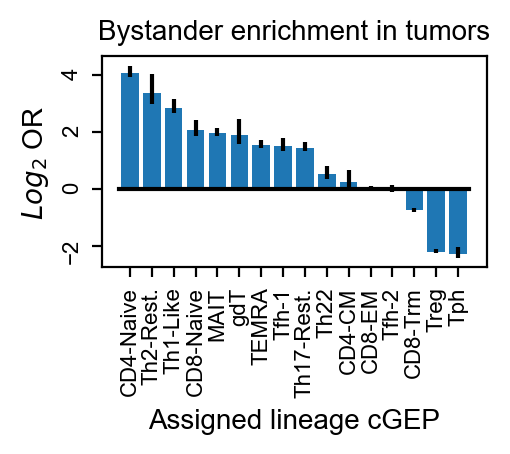

In [38]:
res['error_down'] = res['logOR'] - res['logOR_ci_low']
res['error_up'] = res['logOR_ci_high'] - res['logOR']

(fig,ax) = plt.subplots(1,1, figsize=(2.5,2.2), dpi=200, gridspec_kw={'bottom':.4, 'right':.97, 'left':.2})
ax.bar(x=np.arange(res.shape[0]), height= res['logOR'])
ax.errorbar(np.arange(res.shape[0]), res['logOR'], yerr=res[['error_down', 'error_up']].T,
            fmt='', color='k', ls='none')
ax.plot([-.5, res.shape[0]-.5], [0,0], color='k')
ax.set_xticks(np.arange(res.shape[0]))
ax.set_xticklabels([shorten_map[x] for x in res['GEP']])
ax.tick_params(labelsize=8, rotation=90)
#ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('$Log_{2}$ OR', fontsize=10)
ax.set_xlabel('Assigned lineage cGEP', fontsize=10)
ax.set_title('Bystander enrichment in tumors', fontsize=10)

plt.savefig(os.path.join(figdir, 'CancerBystanderLineageEnrichment.Bar.png'))
plt.savefig(os.path.join(figdir, 'CancerBystanderLineageEnrichment.Bar.pdf'))

In [49]:
res = []
for lin in dat2[0].unique():
    ct = pd.crosstab((dat2[0]==lin).astype(str), dat2['Activation_Status'].astype(str))
    ct = ct.loc[['False', 'True'], ['False', 'True']]
    OR, P = fisher_exact(ct)
    logOR = np.log(OR)
    se_log_or = np.sqrt((1 / ct).sum().sum())  
    ci_low_or = np.exp(logOR - 1.96*se_log_or)
    ci_high_or = np.exp(logOR + 1.96*se_log_or)    
    log2OR = np.log2(OR)
    ci_low_log2OR = np.log2(ci_low_or)
    ci_high_log2OR = np.log2(ci_high_or)    
    
    res.append([lin, P, OR, log2OR, ci_low_log2OR, ci_high_log2OR + 1.96*se_log_or,
                ct.loc['True', 'True'], ct.loc['True', :].sum()])
    
res = pd.DataFrame(res, columns=['GEP', 'P', 'OR', 'logOR', 'logOR_ci_low', 'logOR_ci_high',
                                 'Num_Overlap', 'Num_Lin'])
res = res.sort_values(by='logOR', ascending=False)

Text(0.5, 1.0, 'Activation enrichment')

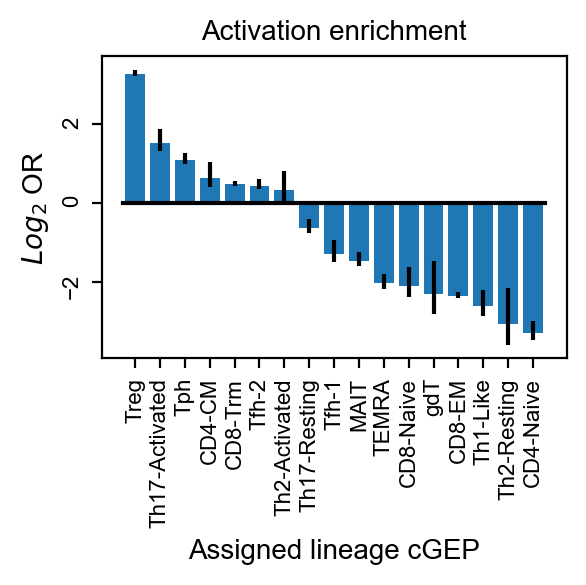

In [50]:
res['error_down'] = res['logOR'] - res['logOR_ci_low']
res['error_up'] = res['logOR_ci_high'] - res['logOR']

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200)
ax.bar(x=np.arange(res.shape[0]), height= res['logOR'])
ax.errorbar(np.arange(res.shape[0]), res['logOR'], yerr=res[['error_down', 'error_up']].T,
            fmt='', color='k', ls='none')
ax.plot([-.5, res.shape[0]-.5], [0,0], color='k')
ax.set_xticks(np.arange(res.shape[0]))
ax.set_xticklabels(res['GEP'])
ax.tick_params(labelsize=8, rotation=90)

ax.set_ylabel('$Log_{2}$ OR', fontsize=10)
ax.set_xlabel('Assigned lineage cGEP', fontsize=10)
ax.set_title('Activation enrichment', fontsize=10)

In [51]:
res

,GEP,P,OR,logOR,logOR_ci_low,logOR_ci_high,Num_Overlap,Num_Lin,error_down,error_up
0,Treg,0.000000e+00,9.667632,3.273163,3.219460,3.364089,12844,17909,0.053703,0.090926
8,Th17-Activated,3.470473e-46,2.857586,1.514797,1.307004,1.866621,425,759,0.207793,0.351824
5,Tph,5.365214e-92,2.138979,1.096923,0.992731,1.273334,1485,3074,0.104191,0.176411
14,CD4-CM,3.292509e-07,1.551941,0.634074,0.394495,1.039717,238,580,0.239579,0.405642
3,CD8-Trm,4.334646e-70,1.385426,0.470330,0.418737,0.557683,5933,16059,0.051592,0.087354
9,Tfh-2,7.498815e-19,1.352271,0.435384,0.340440,0.596140,1492,3980,0.094945,0.160755
13,Th2-Activated,2.138005e-02,1.256449,0.329353,0.050716,0.801126,162,449,0.278637,0.471773
4,Th17-Resting,2.641326e-23,0.646348,-0.629617,-0.757887,-0.412438,646,2840,0.128270,0.217180
6,Tfh-1,1.039840e-42,0.408103,-1.292994,-1.495769,-0.949666,233,1487,0.202775,0.343328
2,MAIT,4.379715e-128,0.359109,-1.477507,-1.611448,-1.250723,533,3723,0.133942,0.226783


In [52]:
ct = pd.crosstab(dat.loc[dat['loc']=='T', 0], dat.loc[dat['loc']=='T', 'Bystander_Bin'])
ct.sort_values(by=True, ascending=False)

Bystander_Bin,False,True
0,,
CD8-EM,12239,11512
CD8-Trm,10020,6039
CD4-Naive,391,5339
Treg,14163,3746
TEMRA,1267,3257
MAIT,844,2879
Th17-Resting,814,2026
Tfh-2,2099,1881
Th1-Like,271,1723


In [53]:
ct.div(ct.sum(axis=0), axis=1).sort_values(by=True, ascending=False)

Bystander_Bin,False,True
0,,
CD8-EM,0.263182,0.270603
CD8-Trm,0.215465,0.141954
CD4-Naive,0.008408,0.125500
Treg,0.304554,0.088054
TEMRA,0.027245,0.076560
MAIT,0.018149,0.067674
Th17-Resting,0.017504,0.047624
Tfh-2,0.045136,0.044215
Th1-Like,0.005827,0.040501


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


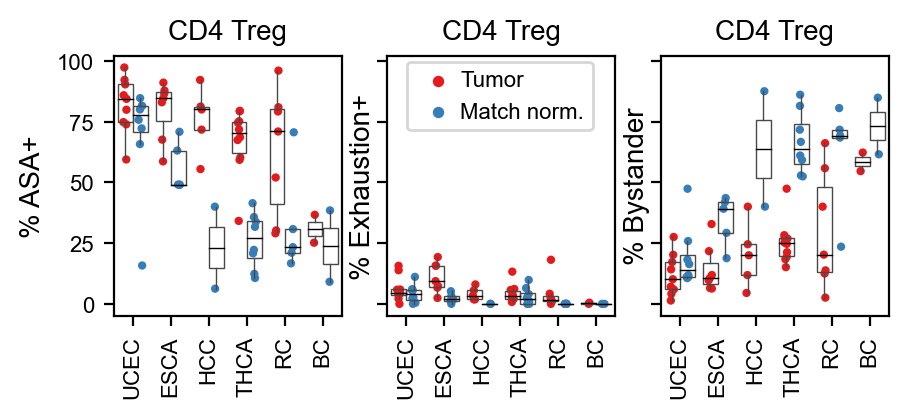

In [54]:
mincells = 10
mintumors = 2
minnormals = 1


(fig, axes) = plt.subplots(1,3, figsize=(5,2), dpi=200, gridspec_kw={'hspace':.6, 'top':.9, 'bottom':.25}, sharey=True)
count = 0 

for i,readout in enumerate(['Activation_Status', 'Exhaustion_Bin', 'Bystander_Bin']):
    for j,lineage in enumerate(['CD4 Treg']):
        dat = actinfo_filt['Pan-Cancer'].copy()
        dat['Pheno2'] = dat['Pheno'].replace({'Cancer':'Tumor', 'Normal':'Match norm.'})
        
        
        ind = (dat['lineage'] == lineage)
        dat = dat.loc[ind, :]
        dat[['individual', 'Pheno2']] = dat[['individual', 'Pheno2']].astype(str)
        sample_stats = dat.groupby(['individual', 'Pheno2', 'cancerType']).count()['Activation_Status'].reset_index().rename(columns={'Activation_Status':'Ncell'})
        num_tumors = sample_stats.loc[(sample_stats['Ncell']>=mincells) & (sample_stats['Pheno2']=='Tumor'), 'cancerType'].value_counts()
        num_normals = sample_stats.loc[(sample_stats['Ncell']>=mincells) & (sample_stats['Pheno2']=='Match norm.'), 'cancerType'].value_counts()
        tumors_to_filt = list(set(num_tumors.index[num_tumors<mintumors]).union(set(num_normals.index[num_normals<minnormals])))        
        dat = dat.loc[~dat['cancerType'].isin(tumors_to_filt), :]

        
        dat[['cancerType']] = dat[['cancerType']].astype(str)
        sample_average = (dat.groupby(['individual', 'Pheno2', 'cancerType'])['CellCycle_Bin', 'Activation_Status', 'Exhaustion_Bin', 'Bystander_Bin'].mean()*100).dropna().reset_index()
        sample_average = pd.merge(left=sample_average, right=sample_stats[['individual', 'Ncell']], on='individual', how='left')
        sample_average = sample_average.loc[sample_average['Ncell']>=mincells, :]
        
        if count == 0:
            order = list(sample_average.loc[sample_average['Pheno2'] == 'Tumor', :].groupby('cancerType')[readout].mean().sort_values(ascending=False).index)

        ax = axes[i]
        sp = sns.stripplot(x='cancerType', y=readout, hue='Pheno2', dodge=True, data=sample_average, order=order, hue_order=['Tumor', 'Match norm.'],
                           palette="Set1", ax=ax, zorder=-1, s=3)
        sns.boxplot(x='cancerType', y=readout, data=sample_average, hue='Pheno2', order=order, hue_order=['Tumor', 'Match norm.'], palette="Set1", ax=ax,
            dodge=True, fliersize=0, showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, zorder=5)


        ax.set_xticklabels(order, rotation=90)
        ax.tick_params(labelsize=8)
        
        if j == 1:
            ax.set_xlabel('Tumor type', fontsize=10)
        else:
            ax.set_xlabel('', fontsize=10)
        
        if readout == 'Exhaustion_Bin':
            ax.set_ylabel('% Exhaustion+', fontsize=10)
        elif readout == 'Bystander_Bin':
            ax.set_ylabel('% Bystander', fontsize=10)
            
        else:
            ax.set_ylabel('% ASA+', fontsize=10)
            
        if (i==1) and (j == 0):
            handles, labels = sp.get_legend_handles_labels()
            ax.legend(bbox_to_anchor=(.95,1.02), handles=handles[:2], labels=labels[:2], fontsize=8, markerscale=.4, handletextpad=0)
        else:
            ax.legend_.remove()
                


        ax.set_title(lineage, fontsize=10)
        count += 1

plt.savefig(os.path.join(figdir, 'CancerVsActivationExhaustionBystander.Treg.Stripplot.png'))
plt.savefig(os.path.join(figdir, 'CancerVsActivationExhaustionBystander.Treg.Stripplot.pdf'))

In [55]:
tregPs = []
for (k,g) in sample_average.groupby('cancerType'):
    T, P =ttest_ind(g.loc[g['Pheno2']=='Tumor', 'Activation_Status'], g.loc[g['Pheno2']=='Match norm.', 'Activation_Status'], equal_var=False)
    tregPs.append([k, T, P])
    
tregPs = pd.DataFrame(tregPs, columns=['Cancer', 'T', 'P']).sort_values(by='P')
tregPs.index = tregPs['Cancer']
tregPs

,Cancer,T,P
Cancer,,,
THCA,THCA,7.007034,0.000003
ESCA,ESCA,3.682395,0.004539
RC,RC,2.167842,0.056407
HCC,HCC,2.952077,0.162947
UCEC,UCEC,1.395970,0.192574
BC,BC,0.451984,0.715153


In [56]:
tregPs.loc['THCA', 'P']

3.0120556840730563e-06

# Covid-19

Text(0.5, 1.0, 'Conventional T-cell')

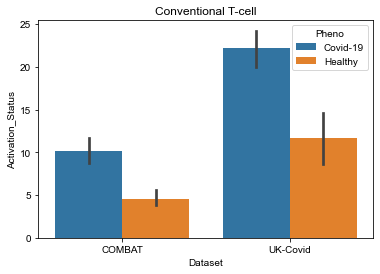

In [57]:
X = actinfo_filt['COMBAT'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
Y = actinfo_filt['UK-Covid'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
merged = pd.concat([X, Y], axis=0)

ind = merged['Gating_Simple'].isin(['CD4 conv', 'CD8 conv'])


sample_average = (merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index()
sample_average.index = sample_average['individual']
count = merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).count()['Activation_Status'].reset_index()
count.index = count['individual']
sample_average['Ncells'] = count.loc[sample_average.index, 'Activation_Status']
ax = sns.barplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average)
ax.set_title('Conventional T-cell')

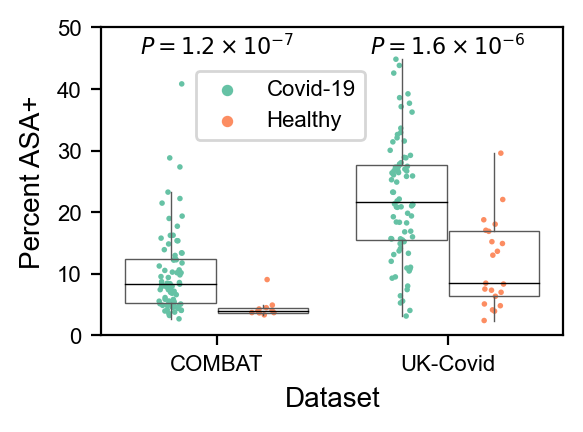

In [58]:
(fig,ax) = plt.subplots(1,1, figsize=(3, 2), dpi=200, gridspec_kw={'left':.2, 'bottom':.2, 'top':.97, 'right':.97})

ind = (sample_average['Ncells']>100)

sp = sns.stripplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average.loc[ind, :], dodge=True, ax=ax, palette="Set2", zorder=-1, s=2)

bp = sns.boxplot(x='Dataset', y='Activation_Status', data=sample_average.loc[ind, :], hue='Pheno', dodge=True, fliersize=0, palette="Set2", showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, ax=ax, zorder=5)
bp.legend_.remove()

handles, labels = sp.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(.18,.6), handles=handles[:2], labels=labels[:2], fontsize=8, markerscale=.4)
ax.set_ylabel('Percent ASA+', fontsize=10)
ax.set_xlabel('Dataset', fontsize=10)

ax.set_ylim([0, 50])

a = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Covid-19'), 'Activation_Status']
b = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Healthy'), 'Activation_Status']
T,P = ttest_ind(a,b, equal_var=False)
P_sci_notation = f"{P:.1e}"
base, exponent = P_sci_notation.split("e")
exponent = int(exponent)  # Convert exponent to integer for clean formatting


ax.text(0, 47, r'$P = {:.1f} \times 10^{{{}}}$'.format(float(base), exponent), fontsize=8, ha='center', va='center')


a = sample_average.loc[(sample_average['Dataset']=='UK-Covid') & (sample_average['Pheno']=='Covid-19'), 'Activation_Status']
b = sample_average.loc[(sample_average['Dataset']=='UK-Covid') & (sample_average['Pheno']=='Healthy'), 'Activation_Status']
T,P = ttest_ind(a,b, equal_var=False)
P_sci_notation = f"{P:.2e}"
base, exponent = P_sci_notation.split("e")
exponent = int(exponent)  # Convert exponent to integer for clean formatting

ax.text(1, 47, r'$P = {:.1f} \times 10^{{{}}}$'.format(float(base), exponent), fontsize=8, ha='center', va='center')

ax.tick_params(labelsize=8)

plt.savefig(os.path.join(figdir, 'CovidVsActivation.Stripplot.png'))
plt.savefig(os.path.join(figdir, 'CovidVsActivation.Stripplot.pdf'))

In [59]:
a = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Covid-19'), 'Activation_Status']
a.mean(), a.min(), a.max()

(10.128209533558005, 2.6957890594254232, 40.83565459610028)

In [60]:
a = sample_average.loc[(sample_average['Dataset']=='UK-Covid') & (sample_average['Pheno']=='Covid-19'), 'Activation_Status']
a.mean(), a.min(), a.max()

(22.183456688316852, 3.14900153609831, 44.844290657439444)

In [61]:
merged['Gating_Simple'].unique()

array(['CD8 conv', 'CD4 conv', 'unconv', 'DP', 'Treg'], dtype=object)

True     392888
False    237312
Name: Gating_Simple, dtype: int64

Text(0.5, 1.0, 'CD4+ T-conv')

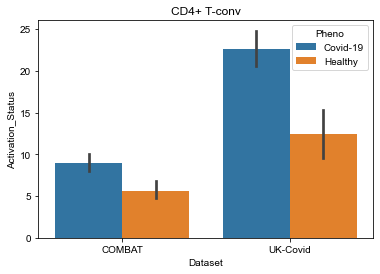

In [66]:
X = actinfo_filt['COMBAT'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
Y = actinfo_filt['UK-Covid'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
merged = pd.concat([X, Y], axis=0)

ind = merged['Gating_Simple'].isin(['CD4 conv'])
display(ind.value_counts())


sample_average = (merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index()
sample_average.index = sample_average['individual']
count = merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).count()['Activation_Status'].reset_index()
count.index = count['individual']
sample_average['Ncells'] = count.loc[sample_average.index, 'Activation_Status']
ax = sns.barplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average)
ax.set_title('CD4+ T-conv')

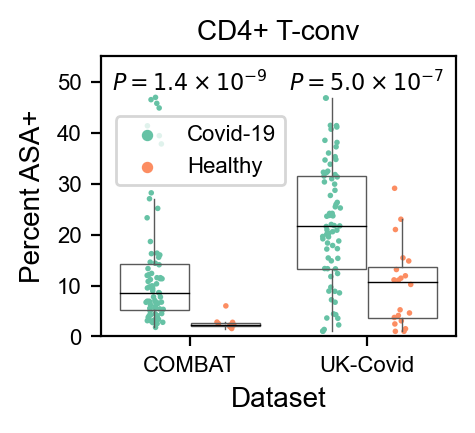

In [70]:
(fig,ax) = plt.subplots(1,1, figsize=(2.3, 2), dpi=200, gridspec_kw={'left':.2, 'bottom':.2, 'top':.9, 'right':.97})

ind = (sample_average['Ncells']>100)

sp = sns.stripplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average.loc[ind, :], dodge=True, ax=ax, palette="Set2", zorder=-1, s=2)

bp = sns.boxplot(x='Dataset', y='Activation_Status', data=sample_average.loc[ind, :], hue='Pheno', dodge=True, fliersize=0, palette="Set2", showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, ax=ax, zorder=5)
bp.legend_.remove()

handles, labels = sp.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(.55,.5), handles=handles[:2], labels=labels[:2], fontsize=8, markerscale=.4)
ax.set_ylabel('Percent ASA+', fontsize=10)
ax.set_xlabel('Dataset', fontsize=10)
ax.set_title('CD4+ T-conv', fontsize=10)

ax.set_ylim([0, 55])

a = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Covid-19'), 'Activation_Status']
b = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Healthy'), 'Activation_Status']
T,P = ttest_ind(a,b, equal_var=False)
P_sci_notation = f"{P:.1e}"
base, exponent = P_sci_notation.split("e")
exponent = int(exponent)  # Convert exponent to integer for clean formatting


ax.text(0, 50, r'$P = {:.1f} \times 10^{{{}}}$'.format(float(base), exponent), fontsize=8, ha='center', va='center')


a = sample_average.loc[(sample_average['Dataset']=='UK-Covid') & (sample_average['Pheno']=='Covid-19'), 'Activation_Status']
b = sample_average.loc[(sample_average['Dataset']=='UK-Covid') & (sample_average['Pheno']=='Healthy'), 'Activation_Status']
T,P = ttest_ind(a,b, equal_var=False)
P_sci_notation = f"{P:.2e}"
base, exponent = P_sci_notation.split("e")
exponent = int(exponent)  # Convert exponent to integer for clean formatting

ax.text(1, 50, r'$P = {:.1f} \times 10^{{{}}}$'.format(float(base), exponent), fontsize=8, ha='center', va='center')

ax.tick_params(labelsize=8)

plt.savefig(os.path.join(figdir, 'CovidVsActivation.CD4.Stripplot.png'))
plt.savefig(os.path.join(figdir, 'CovidVsActivation.CD4.Stripplot.pdf'))

In [71]:
sample_average.loc[ind, :].groupby(['Dataset', 'Pheno'])['Activation_Status'].median()

Dataset   Pheno   
COMBAT    Covid-19     8.554510
          Healthy      2.235815
UK-Covid  Covid-19    21.714286
          Healthy     10.635229
Name: Activation_Status, dtype: float64

False    488108
True     142092
Name: Gating_Simple, dtype: int64

Text(0.5, 1.0, 'CD8+ T-conv')

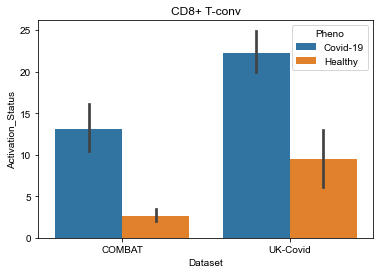

In [72]:
X = actinfo_filt['COMBAT'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
Y = actinfo_filt['UK-Covid'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
merged = pd.concat([X, Y], axis=0)

ind = merged['Gating_Simple'].isin(['CD8 conv'])
display(ind.value_counts())


sample_average = (merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index()
sample_average.index = sample_average['individual']
count = merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).count()['Activation_Status'].reset_index()
count.index = count['individual']
sample_average['Ncells'] = count.loc[sample_average.index, 'Activation_Status']
ax = sns.barplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average)
ax.set_title('CD8+ T-conv')

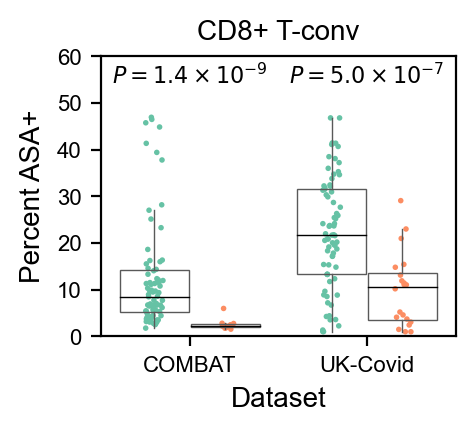

In [73]:
(fig,ax) = plt.subplots(1,1, figsize=(2.3, 2), dpi=200, gridspec_kw={'left':.2, 'bottom':.2, 'top':.9, 'right':.97})

ind = (sample_average['Ncells']>100)

sp = sns.stripplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average.loc[ind, :], dodge=True, ax=ax, palette="Set2", zorder=-1, s=2)

bp = sns.boxplot(x='Dataset', y='Activation_Status', data=sample_average.loc[ind, :], hue='Pheno', dodge=True, fliersize=0, palette="Set2", showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, ax=ax, zorder=5)
bp.legend_.remove()

#handles, labels = sp.get_legend_handles_labels()
#ax.legend(bbox_to_anchor=(.18,.6), handles=handles[:2], labels=labels[:2], fontsize=8, markerscale=.4)
ax.set_ylabel('Percent ASA+', fontsize=10)
ax.set_xlabel('Dataset', fontsize=10)
ax.set_title('CD8+ T-conv', fontsize=10)

ax.set_ylim([0, 60])

a = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Covid-19'), 'Activation_Status']
b = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Healthy'), 'Activation_Status']
T,P = ttest_ind(a,b, equal_var=False)
P_sci_notation = f"{P:.1e}"
base, exponent = P_sci_notation.split("e")
exponent = int(exponent)  # Convert exponent to integer for clean formatting


ax.text(0, 56, r'$P = {:.1f} \times 10^{{{}}}$'.format(float(base), exponent), fontsize=8, ha='center', va='center')


a = sample_average.loc[(sample_average['Dataset']=='UK-Covid') & (sample_average['Pheno']=='Covid-19'), 'Activation_Status']
b = sample_average.loc[(sample_average['Dataset']=='UK-Covid') & (sample_average['Pheno']=='Healthy'), 'Activation_Status']
T,P = ttest_ind(a,b, equal_var=False)
P_sci_notation = f"{P:.2e}"
base, exponent = P_sci_notation.split("e")
exponent = int(exponent)  # Convert exponent to integer for clean formatting

ax.text(1, 56, r'$P = {:.1f} \times 10^{{{}}}$'.format(float(base), exponent), fontsize=8, ha='center', va='center')

ax.tick_params(labelsize=8)

plt.savefig(os.path.join(figdir, 'CovidVsActivation.CD8.Stripplot.png'))
plt.savefig(os.path.join(figdir, 'CovidVsActivation.CD8.Stripplot.pdf'))

In [74]:
sample_average.loc[ind, :].groupby(['Dataset', 'Pheno'])['Activation_Status'].median()

Dataset   Pheno   
COMBAT    Covid-19     8.554510
          Healthy      2.235815
UK-Covid  Covid-19    21.714286
          Healthy     10.635229
Name: Activation_Status, dtype: float64

<AxesSubplot:xlabel='Dataset', ylabel='Activation_Status'>

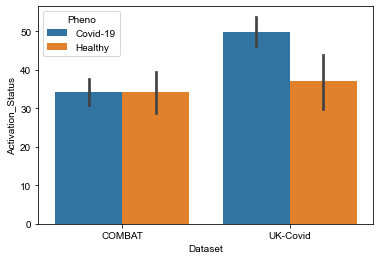

In [75]:
X = actinfo_filt['COMBAT'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
Y = actinfo_filt['UK-Covid'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
merged = pd.concat([X, Y], axis=0)

ind = (merged['Gating_Simple']=='Treg')


sample_average = (merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index()
sample_average.index = sample_average['individual']
count = merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).count()['Activation_Status'].reset_index()
count.index = count['individual']
sample_average['Ncells'] = count.loc[sample_average.index, 'Activation_Status']
sns.barplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average)

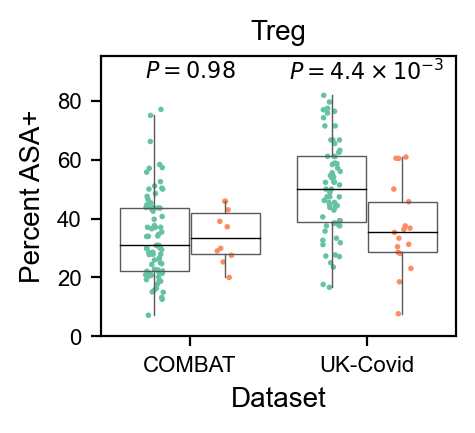

In [76]:
(fig,ax) = plt.subplots(1,1, figsize=(2.3, 2), dpi=200, gridspec_kw={'left':.2, 'bottom':.2, 'top':.9, 'right':.97})

ind = (sample_average['Ncells']>10)

sp = sns.stripplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average.loc[ind, :], dodge=True, ax=ax, palette="Set2", zorder=-1, s=2)

bp = sns.boxplot(x='Dataset', y='Activation_Status', data=sample_average.loc[ind, :], hue='Pheno', dodge=True, fliersize=0, palette="Set2", showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, ax=ax, zorder=5)
bp.legend_.remove()

#handles, labels = sp.get_legend_handles_labels()
#ax.legend(bbox_to_anchor=(.18,.6), handles=handles[:2], labels=labels[:2], fontsize=8, markerscale=.4)
ax.set_ylabel('Percent ASA+', fontsize=10)
ax.set_xlabel('Dataset', fontsize=10)
ax.set_title('Treg', fontsize=10)

ax.set_ylim([0, 95])

a = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Covid-19'), 'Activation_Status']
b = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Healthy'), 'Activation_Status']
T,P = ttest_ind(a,b, equal_var=False)

ax.text(0, 90, r'$P = {:.2f}$'.format(P), fontsize=8, ha='center', va='center')


a = sample_average.loc[(sample_average['Dataset']=='UK-Covid') & (sample_average['Pheno']=='Covid-19'), 'Activation_Status']
b = sample_average.loc[(sample_average['Dataset']=='UK-Covid') & (sample_average['Pheno']=='Healthy'), 'Activation_Status']
T,P = ttest_ind(a,b, equal_var=False)
P_sci_notation = f"{P:.2e}"
base, exponent = P_sci_notation.split("e")
exponent = int(exponent)  # Convert exponent to integer for clean formatting

ax.text(1, 90, r'$P = {:.1f} \times 10^{{{}}}$'.format(float(base), exponent), fontsize=8, ha='center', va='center')

ax.tick_params(labelsize=8)

plt.savefig(os.path.join(figdir, 'CovidVsActivation.Stripplot.Treg.png'))
plt.savefig(os.path.join(figdir, 'CovidVsActivation.Stripplot.Treg.pdf'))

In [77]:
X = actinfo_filt['COMBAT'][['Activation_Status', 'sample', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
X[['Dataset', 'Pheno', 'Gating_Simple', 'sample']] = X[['Dataset', 'Pheno', 'Gating_Simple', 'sample']].astype(str)

sample_average = (X.groupby(['Dataset', 'Pheno', 'Gating_Simple', 'sample']).mean()*100).reset_index()
sample_average_pivot = sample_average.pivot_table(index='sample', columns='Gating_Simple', values='Activation_Status')
ind = (sample_average_pivot['CD8 conv']>35) & (sample_average_pivot['CD4 conv']<15) 
weirdones = sample_average_pivot.loc[ind, :]
weirdones

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Gating_Simple,CD4 conv,CD8 conv,DP,Treg,unconv
sample,,,,,
S00020-Ja003,6.556082,46.511628,54.411765,21.666667,10.810811
S00039-Ja001,11.336898,37.815126,21.428571,30.000000,15.189873
S00043-Ja005,14.504193,41.379310,63.855422,57.055215,3.208556
S00049-Ja003,9.837134,45.784784,46.666667,35.416667,4.000000
S00060-Ja005,13.125453,44.881306,58.620690,50.000000,10.256410
S00113-Ja005,14.802632,67.723669,64.843750,25.925926,13.114754
S00126-Ja003,9.517486,46.964064,51.219512,20.149254,12.307692


In [78]:
sample_info = actinfo_filt['COMBAT'][['individual', 'sample', 'Source', 'TimeSinceOnset','Pheno', 'Dataset']].drop_duplicates()
sample_info.loc[sample_info['sample'].isin(weirdones.index), :]

,individual,sample,Source,TimeSinceOnset,Pheno,Dataset
AAACGGGCACGCATCG-1-gPlexA1,S00043,S00043-Ja005,COVID_CRIT,13.0,Covid-19,COMBAT
AAACCTGTCTAACTCT-1-gPlexC1,S00020,S00020-Ja003,COVID_CRIT,25.0,Covid-19,COMBAT
AAACGGGAGTACGCCC-1-gPlexC1,S00039,S00039-Ja001,COVID_SEV,22.0,Covid-19,COMBAT
AAACCTGCACATTAGC-1-gPlexF1,S00113,S00113-Ja005,COVID_MILD,6.0,Covid-19,COMBAT
AAACGGGGTTCGTCTC-1-gPlexF1,S00060,S00060-Ja005,COVID_SEV,9.0,Covid-19,COMBAT
AAACCTGCATGACGGA-1-gPlexG1,S00049,S00049-Ja003,COVID_MILD,5.0,Covid-19,COMBAT
AAACCTGGTCAGAATA-1-gPlexH1,S00126,S00126-Ja003,COVID_MILD,11.0,Covid-19,COMBAT


In [79]:
count_fn = params.loc['COMBAT', 'raw_counts_filt_fn']
adata = sc.read(count_fn)

Only considering the two last: ['.ADTfixed20230831FiltForcNMF', '.h5ad'].
Only considering the two last: ['.ADTfixed20230831FiltForcNMF', '.h5ad'].


In [80]:
sample_info = adata.obs[['COMBAT_ID', 'scRNASeq_sample_ID',
       'COMBAT_participant_timepoint_ID', 'Source', 'Age', 'Sex', 'Race',
       'BMI', 'Hospitalstay', 'Death28', 'Institute',
       'PreExistingHeartDisease', 'PreExistingLungDisease',
       'PreExistingKidneyDisease', 'PreExistingDiabetes',
       'PreExistingHypertension', 'PreExistingImmunocompromised', 'Smoking',
       'Symptomatic', 'Requiredvasoactive', 'Respiratorysupport',
       'SARSCoV2PCR', 'Outcome', 'TimeSinceOnset', 'Ethnicity', 'Pool_ID']]
sample_info = sample_info.drop_duplicates()

In [81]:
sample_info.loc[sample_info['COMBAT_participant_timepoint_ID'].isin(weirdones.index), :].T

,AAACGGGCACGCATCG-1-gPlexA1,AAACCTGTCTAACTCT-1-gPlexC1,AAACGGGAGTACGCCC-1-gPlexC1,AAACCTGCACATTAGC-1-gPlexF1,AAACGGGGTTCGTCTC-1-gPlexF1,AAACCTGCATGACGGA-1-gPlexG1,AAACCTGGTCAGAATA-1-gPlexH1
COMBAT_ID,S00043,S00020,S00039,S00113,S00060,S00049,S00126
scRNASeq_sample_ID,S00043-Ja005E-PBCa,S00020-Ja003E-PBCa,S00039-Ja001E-PBCa,S00113-Ja005E-PBCa,S00060-Ja005E-PBCa,S00049-Ja003E-PBCa,S00126-Ja003E-PBCa
COMBAT_participant_timepoint_ID,S00043-Ja005,S00020-Ja003,S00039-Ja001,S00113-Ja005,S00060-Ja005,S00049-Ja003,S00126-Ja003
Source,COVID_CRIT,COVID_CRIT,COVID_SEV,COVID_MILD,COVID_SEV,COVID_MILD,COVID_MILD
Age,5.0,6.0,7.0,7.0,1.8,7.0,8.0
Sex,0,0,0,1,0,1,0
Race,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
BMI,5,1,5,1,1,5,5
Hospitalstay,6.0,4.0,1.0,4.0,4.0,2.0,3.0
Death28,0,0,1,0,0,0,0


In [84]:
overlap = list(set(adata.obs.index).intersection(X.index))
adata = adata[overlap, :]
adata.obs['Gating_Simple'] = X.loc[overlap, 'Gating_Simple']
adata.obs[['Gating_Simple', 'COMBAT_participant_timepoint_ID']] = adata.obs[['Gating_Simple', 'COMBAT_participant_timepoint_ID']].astype(str)
summary = []
for (k,g) in adata.obs.groupby(['Gating_Simple', 'COMBAT_participant_timepoint_ID']):
    vc = g['TCR_clone_ID'].value_counts().drop('nan')
    summary.append([k[0], k[1], g.shape[0], vc.sum(), vc.index[0], vc.iloc[0], vc.iloc[0] / vc.sum(), vc.index[1], vc.iloc[1], vc.iloc[1] / vc.sum()])
    
summary = pd.DataFrame(summary)
summary.columns = ['Gating_Simple', 'COMBAT_participant_timepoint_ID', 'N_cells', 'N_cells_with_tcr', 'max_tcr', 'max_tcr_count',
                   'max_tcr_frac', 'second_tcr', 'second_tcr_count', 'second_tcr_frac']

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  This is separate from the ipykernel package so we can avoid doing imports until
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


In [89]:

summary.head()

,Gating_Simple,COMBAT_participant_timepoint_ID,N_cells,N_cells_with_tcr,max_tcr,max_tcr_count,max_tcr_frac,second_tcr,second_tcr_count,second_tcr_frac
0,CD4 conv,G05061-Ja005,1933,1858,TRA_CAVELGVNNDMRF-TRB_CASSQEVDSGVFGGSPFYEQYF,5,0.002691,TRA_CGTEGDSQFYF-TRB_CASSFRRLGLNTGELFF,3,0.001615
1,CD4 conv,G05064-Ja005,4084,3854,TRA_CASNYNTDKLIF-TRB_CASSETDRVPGNTIYF,3,0.000778,TRA_CAPYYGGSQGNLIF-TRB_CASRGTHQTPYGYTF,3,0.000778
2,CD4 conv,G05073-Ja005,3467,3276,TRA_CALRNTGGFKTIF-TRB_CASSSDMNQPQHF,21,0.006410,TRA_CAYRRVRETSGSRLTF-TRB_CASSWISTDTQYF,11,0.003358
3,CD4 conv,G05077-Ja005,1468,1406,TRA_CAEEIGSARQLTF-TRB_CASSLVGSNQPQHF,13,0.009246,TRA_CVVSDRNPGNQFYF-TRB_CASSPGSGTYNEQFF,10,0.007112
4,CD4 conv,G05078-Ja005,3615,3503,TRA_CALDQGSSYKLIF-TRB_CSALRGVAITDTQYF,7,0.001998,TRA_CALSEARYNFNKFYF-TRB_CASSYLGEQYF,7,0.001998


<AxesSubplot:xlabel='weirdone', ylabel='top2tcrfrac'>

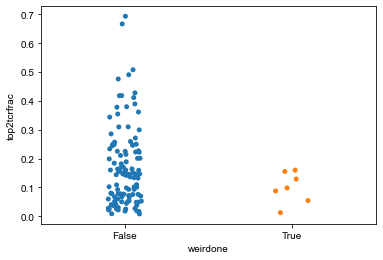

In [115]:
ind = summary['Gating_Simple'].isin(['CD8 conv']) 
ind1 = summary['Gating_Simple'].isin(['CD8 conv']) & summary['COMBAT_participant_timepoint_ID'].isin(weirdones.index)
ind2 = summary['Gating_Simple'].isin(['CD8 conv']) & ~summary['COMBAT_participant_timepoint_ID'].isin(weirdones.index)
summary['weirdone'] =  summary['COMBAT_participant_timepoint_ID'].isin(weirdones.index)
summary['top2tcrfrac'] = summary.loc[:, ['max_tcr_frac', 'second_tcr_frac'] ].sum(axis=1)
sns.stripplot(x='weirdone', y='top2tcrfrac', data=summary.loc[ind, :])

In [117]:
ttest_ind(summary.loc[ind1, 'top2tcrfrac'], summary.loc[ind2, 'top2tcrfrac'], equal_var=False)

Ttest_indResult(statistic=-2.914861852098991, pvalue=0.01335240113614866)

<AxesSubplot:xlabel='weirdone', ylabel='top2tcrfrac'>

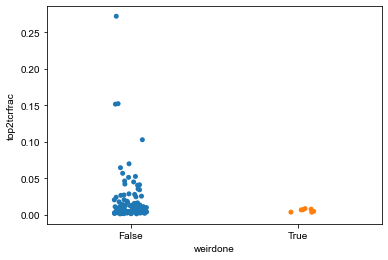

In [118]:
ind = summary['Gating_Simple'].isin(['CD4 conv']) 
ind1 = summary['Gating_Simple'].isin(['CD4 conv']) & summary['COMBAT_participant_timepoint_ID'].isin(weirdones.index)
ind2 = summary['Gating_Simple'].isin(['CD4 conv']) & ~summary['COMBAT_participant_timepoint_ID'].isin(weirdones.index)
summary['weirdone'] =  summary['COMBAT_participant_timepoint_ID'].isin(weirdones.index)
summary['top2tcrfrac'] = summary.loc[:, ['max_tcr_frac', 'second_tcr_frac'] ].sum(axis=1)
sns.stripplot(x='weirdone', y='top2tcrfrac', data=summary.loc[ind, :])

In [119]:
ttest_ind(summary.loc[ind1, 'top2tcrfrac'], summary.loc[ind2, 'top2tcrfrac'], equal_var=False)

Ttest_indResult(statistic=-3.651605359699113, pvalue=0.0003874155067848997)

<AxesSubplot:xlabel='weirdone', ylabel='top2tcrfrac'>

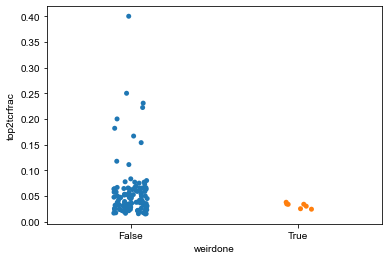

In [120]:
ind = summary['Gating_Simple'].isin(['Treg']) 
ind1 = summary['Gating_Simple'].isin(['Treg']) & summary['COMBAT_participant_timepoint_ID'].isin(weirdones.index)
ind2 = summary['Gating_Simple'].isin(['Treg']) & ~summary['COMBAT_participant_timepoint_ID'].isin(weirdones.index)
summary['weirdone'] =  summary['COMBAT_participant_timepoint_ID'].isin(weirdones.index)
summary['top2tcrfrac'] = summary.loc[:, ['max_tcr_frac', 'second_tcr_frac'] ].sum(axis=1)
sns.stripplot(x='weirdone', y='top2tcrfrac', data=summary.loc[ind, :])

In [126]:
usage_fn = params.loc['COMBAT', 'tcat_fn']
usage = pd.read_csv(usage_fn, sep='\t', index_col=0)
usage = usage.rename(columns=rename_map)
usage_norm = usage.div(usage.sum(axis=1), axis=0)
usage_norm.head()

,CellCycle-G2M,Translation,HLA,ISG,Mito,Doublet-RBC,gdT-Blood,CellCycle-S,Cytotoxic,Doublet-Platelet,...,Tfh-2,OX40/EBI3-Activation,TXNIP/H1FX,YPEL5/JUNB,Doublet-Fibroblast,SOX4/TOX2,CD40LG/TXNIP,Tph,Exhaustion,Tfh-1
AAACCTGAGCGGATCA-1-gPlexA1,0.000114,0.000197,0.050447,0.000394,2.976725e-07,0.000678,0.026504,0.000456,0.328680,0.000905,...,0.004894,0.002549,0.000733,0.002878,0.007332,0.002146,0.002679,0.016983,0.016611,0.012907
AAACCTGCAGCTCGAC-1-gPlexA1,0.000134,0.234478,0.002651,0.011165,4.850446e-06,0.000582,0.012246,0.002683,0.005275,0.001425,...,0.003794,0.010843,0.044205,0.014869,0.001485,0.005787,0.031758,0.004158,0.001973,0.007829
AAACCTGCATCTATGG-1-gPlexA1,0.000073,0.011136,0.067649,0.002802,2.252025e-04,0.001020,0.034474,0.001005,0.120184,0.001089,...,0.009841,0.001386,0.004685,0.004597,0.005090,0.001117,0.057629,0.006502,0.012211,0.017336
AAACCTGGTCTCTCTG-1-gPlexA1,0.000524,0.214455,0.004636,0.026641,7.475370e-06,0.000764,0.006035,0.004994,0.010866,0.002153,...,0.011710,0.053980,0.021231,0.004090,0.001097,0.000952,0.017101,0.003815,0.002443,0.010850
AAACCTGTCACCGGGT-1-gPlexA1,0.000784,0.046476,0.064127,0.002578,3.487247e-07,0.001031,0.042210,0.000432,0.082531,0.001161,...,0.002736,0.011504,0.006414,0.003572,0.000203,0.001019,0.002647,0.001083,0.056630,0.004602


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

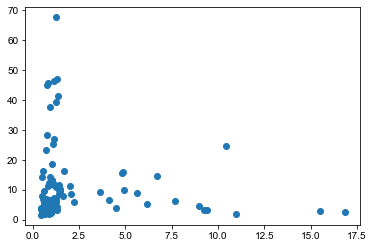

In [153]:
X = actinfo_filt['COMBAT'][['Activation_Status', 'individual', 'sample', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
X['ISG'] = usage_norm.loc[X.index, 'ISG']
ind = X['Gating_Simple'].isin(['CD8 conv'])
X[['Dataset', 'Pheno', 'individual', 'sample']] = X[['Dataset', 'Pheno', 'individual', 'sample']].astype(str)
X['weirdone'] =  X['sample'].isin(weirdones.index)



sample_average = (X.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual', 'sample']).mean()*100).reset_index()
sample_average.index = sample_average['individual']
count = X.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).count()['Activation_Status'].reset_index()
count.index = count['individual']
sample_average['Ncells'] = count.loc[sample_average.index, 'Activation_Status']
sample_average = sample_average.loc[sample_average['Pheno']!= 'nan', :]
sample_average = sample_average.loc[sample_average['Pheno']!= 'nan', :]

sample_average['weirdone'] =  sample_average['sample'].isin(weirdones.index)

plt.scatter(sample_average['ISG'], sample_average['Activation_Status'])

<AxesSubplot:xlabel='weirdone', ylabel='Ncells'>

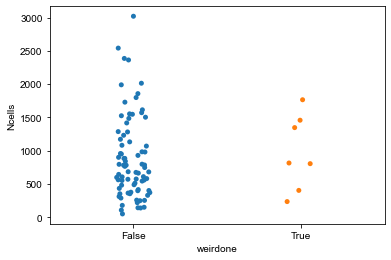

In [150]:
sns.stripplot(x='weirdone', y='Ncells', data=sample_average)

<AxesSubplot:xlabel='weirdone', ylabel='ISG'>

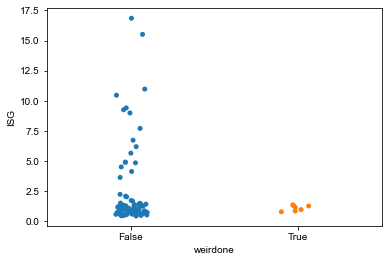

In [151]:
sns.stripplot(x='weirdone', y='ISG', data=sample_average)

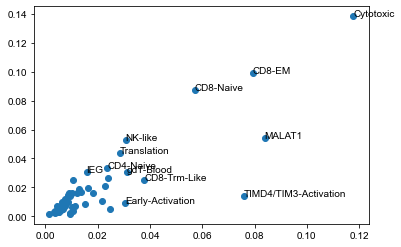

In [172]:
usage_norm
ind1 = (X['weirdone']==True) & (X['Gating_Simple']=='CD8 conv') & (X['Pheno']=='Covid-19')
ind2 = (X['weirdone']==False) & (X['Gating_Simple']=='CD8 conv') & (X['Pheno']=='Covid-19')
x = usage_norm.loc[ind1.index[ind1], :].sum(axis=0)
x = x.div(x.sum())

y = usage_norm.loc[ind2.index[ind2], :].sum(axis=0)
y = y.div(y.sum())


plt.scatter(x,y)
for i in x.index:
    if (x[i]>.03) or (y[i]>.03):
        plt.text(x[i], y[i], i)


# Covid-19 severity

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


<AxesSubplot:xlabel='Dataset', ylabel='Activation_Status'>

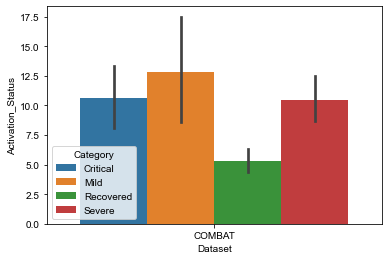

In [194]:
X = actinfo_filt['COMBAT'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset', 'Source']]
X[['Source', 'Dataset', 'individual']] = X[['Source', 'Dataset', 'individual']].astype(str)
#ind = (X['Gating_Simple']=='CD4 conv') & (X['Pheno'] == 'Covid-19')
ind = (X['Pheno'] == 'Covid-19') & (X['Gating_Simple']!='Treg')
#ind = (X['Pheno'] == 'Covid-19') & (X['Gating_Simple']=='CD8 conv')
X = X.loc[ind, :]
X['Category'] = X['Source'].replace({'COVID_CRIT':'Critical', 'COVID_SEV':'Severe', 'COVID_MILD':'Mild',
                                     'COVID_HCW_MILD':'Recovered', 'COVID_LDN':'Critical'})


sample_average = (X.groupby(['Dataset', 'Category', 'individual']).mean()*100).reset_index()
sample_average.index = sample_average['individual']
count = X.groupby(['Dataset', 'Category', 'individual']).count()['Activation_Status'].reset_index()
count.index = count['individual']
sample_average['Ncells'] = count.loc[sample_average.index, 'Activation_Status'].values
sns.barplot(x='Dataset', y='Activation_Status', hue='Category', data=sample_average)

[Text(0, 0, 'Recovered'),
 Text(1, 0, 'Mild'),
 Text(2, 0, 'Severe'),
 Text(3, 0, 'Critical')]

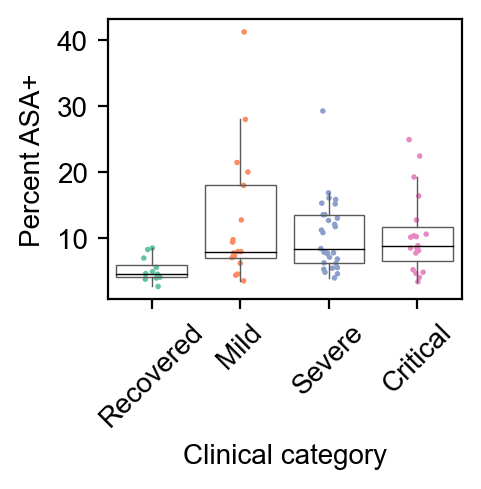

In [195]:
(fig,ax) = plt.subplots(1,1, figsize=(2.3, 2), dpi=200, gridspec_kw={'left':.2, 'bottom':.2, 'top':.9, 'right':.97})

ind = (sample_average['Ncells']>10)
order = ['Recovered', 'Mild', 'Severe', 'Critical']

sp = sns.stripplot(x='Category', y='Activation_Status',data=sample_average.loc[ind, :],
                   dodge=True, ax=ax, palette="Set2", zorder=-1, s=2, order=order)

bp = sns.boxplot(x='Category', y='Activation_Status', data=sample_average.loc[ind, :],  dodge=True, fliersize=0, palette="Set2", showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, ax=ax, zorder=5, order=order)

#handles, labels = sp.get_legend_handles_labels()
#ax.legend(bbox_to_anchor=(.18,.6), handles=handles[:2], labels=labels[:2], fontsize=8, markerscale=.4)
ax.set_ylabel('Percent ASA+', fontsize=10)
ax.set_xlabel('Clinical category', fontsize=10)
ax.set_xticklabels(order, rotation=45)

#plt.savefig(os.path.join(figdir, 'CovidVsActivation.Stripplot.Treg.png'))
#plt.savefig(os.path.join(figdir, 'CovidVsActivation.Stripplot.Treg.pdf'))

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


<AxesSubplot:xlabel='Dataset', ylabel='Activation_Status'>

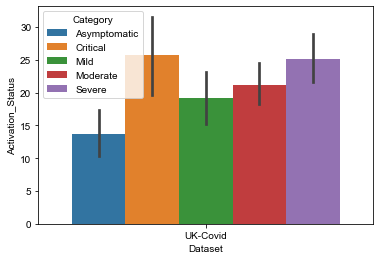

In [213]:
X = actinfo_filt['UK-Covid'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset', 'Status_on_day_collection_summary']]
X[['Status_on_day_collection_summary', 'Dataset', 'individual']] = X[['Status_on_day_collection_summary', 'Dataset', 'individual']].astype(str)
ind = (X['Gating_Simple']!='Treg') & ((X['Pheno'] == 'Covid-19') | (X['Status_on_day_collection_summary'] == 'Asymptomatic'))
X = X.loc[ind, :]
X['Category'] = X['Status_on_day_collection_summary']
sample_average = (X.groupby(['Dataset', 'Category', 'individual']).mean()*100).reset_index()
sample_average.index = sample_average['individual']
count = X.groupby(['Dataset', 'Category', 'individual']).count()['Activation_Status'].reset_index()
count.index = count['individual']
sample_average['Ncells'] = count.loc[sample_average.index, 'Activation_Status'].values
sns.barplot(x='Dataset', y='Activation_Status', hue='Category', data=sample_average)

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


<AxesSubplot:xlabel='Dataset', ylabel='Activation_Status'>

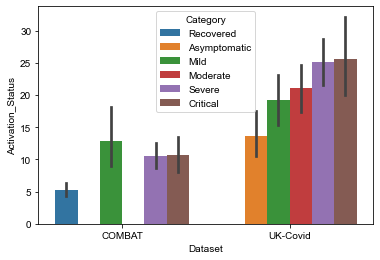

In [225]:
X = actinfo_filt['COMBAT'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset', 'Source']]
X[['Source', 'Dataset', 'individual']] = X[['Source', 'Dataset', 'individual']].astype(str)
#ind = (X['Gating_Simple']=='CD4 conv') & (X['Pheno'] == 'Covid-19')
ind = (X['Pheno'] == 'Covid-19') & (X['Gating_Simple']!='Treg')
#ind = (X['Pheno'] == 'Covid-19') & (X['Gating_Simple']=='CD8 conv')
X = X.loc[ind, :]
X['Category'] = X['Source'].replace({'COVID_CRIT':'Critical', 'COVID_SEV':'Severe', 'COVID_MILD':'Mild',
                                     'COVID_HCW_MILD':'Recovered', 'COVID_LDN':'Critical'})

Y = actinfo_filt['UK-Covid'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset', 'Status_on_day_collection_summary']]
Y[['Status_on_day_collection_summary', 'Dataset', 'individual']] = Y[['Status_on_day_collection_summary', 'Dataset', 'individual']].astype(str)
ind = (Y['Gating_Simple']!='Treg') & ((Y['Pheno'] == 'Covid-19') | (Y['Status_on_day_collection_summary'] == 'Asymptomatic'))
Y = Y.loc[ind, :]
Y['Category'] = Y['Status_on_day_collection_summary']

cols = ['Activation_Status', 'individual', 'Dataset', 'Category', 'Gating_Simple']
merged = pd.concat([X[cols], Y[cols]], axis=0)



sample_average = (merged.groupby(['Dataset', 'Category', 'individual']).mean()*100).reset_index()
sample_average.index = sample_average['individual']

count = merged.groupby(['Dataset', 'Category', 'individual']).count()['Activation_Status'].reset_index()
count.index = count['individual']
sample_average['Ncells'] = count.loc[sample_average.index, 'Activation_Status']

hue_order = ['Recovered', 'Asymptomatic', 'Mild', 'Moderate', 'Severe', 'Critical']
sns.barplot(x='Dataset', y='Activation_Status', hue='Category', data=sample_average, hue_order=hue_order)

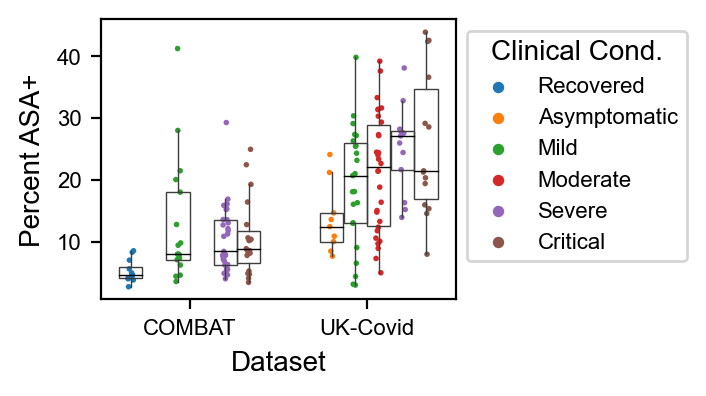

In [232]:
(fig,ax) = plt.subplots(1,1, figsize=(2.3, 2), dpi=200, gridspec_kw={'left':.2, 'bottom':.2, 'top':.9, 'right':.97})

ind = (sample_average['Ncells']>20)

sp = sns.stripplot(x='Dataset', y='Activation_Status', hue='Category',
                   data=sample_average.loc[ind, :], dodge=True, ax=ax, palette="tab10", zorder=-1, s=2,
                  hue_order=hue_order)

bp = sns.boxplot(x='Dataset', y='Activation_Status', data=sample_average.loc[ind, :], hue='Category', dodge=True, fliersize=0,
                 palette="tab10", showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, ax=ax, zorder=5, hue_order=hue_order)
bp.legend_.remove()

handles, labels = sp.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(1,1), handles=handles[:6], labels=labels[:6], fontsize=8, markerscale=.4, title='Clinical Cond.')
ax.set_ylabel('Percent ASA+', fontsize=10)
ax.set_xlabel('Dataset', fontsize=10)
#ax.set_title('Treg', fontsize=10)

ax.tick_params(labelsize=8)

#plt.savefig(os.path.join(figdir, 'CovidVsActivation.Stripplot.Treg.png'))
#plt.savefig(os.path.join(figdir, 'CovidVsActivation.Stripplot.Treg.pdf'))

# Vaccine

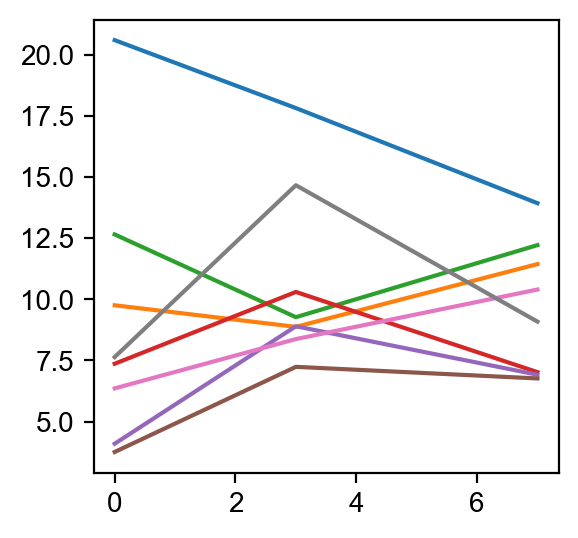

In [99]:
merged = actinfo['HIV-Vaccine'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']].dropna()
ind = (merged['Gating_Simple']!='Treg')

sample_average = (merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index().dropna()
sample_average_perday = sample_average.pivot_table(index='individual', columns='Pheno', values='Activation_Status')
sample_average_perday.columns = [0, 3, 7]

(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
for i in sample_average_perday.index:
    ax.plot(sample_average_perday.columns, sample_average_perday.loc[i, :])

Text(0.5, 1.0, 'HIV vaccine')

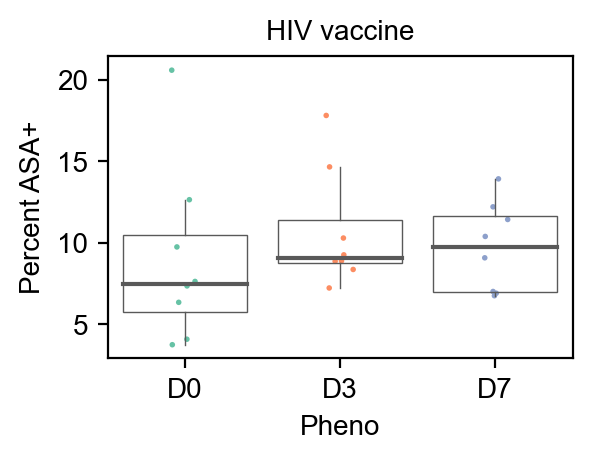

In [125]:
merged = actinfo['HIV-Vaccine']
ind = (merged['Gating_Simple']!='Treg')
sample_average = (merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index().dropna()
sample_average = sample_average.loc[sample_average['individual'] != 'Control', :]


(fig,ax) = plt.subplots(1,1, figsize=(3, 2), dpi=200)
sp = sns.stripplot(x='Pheno', y='Activation_Status', data=sample_average, dodge=True, ax=ax, palette="Set2", zorder=-1, s=2)

bp = sns.boxplot(x='Pheno', y='Activation_Status', data=sample_average,  dodge=True, fliersize=0, palette="Set2", showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, ax=ax, zorder=5)

ax.set_ylabel('Percent ASA+', fontsize=10)
ax.set_title('HIV vaccine', fontsize=10)

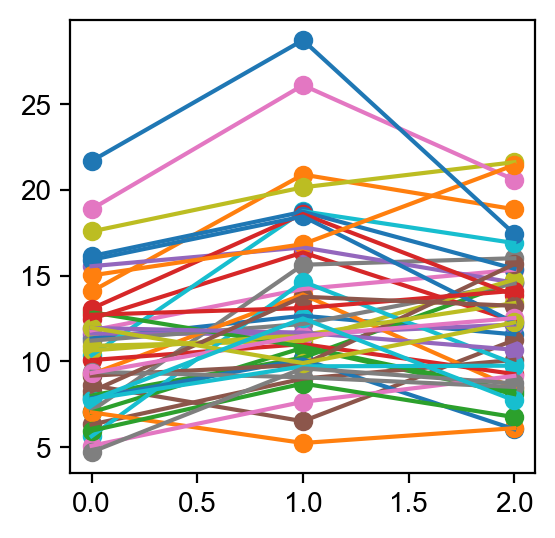

In [118]:
merged = actinfo['Sparks']
ind = (merged['Gating_Simple']!='Treg')
sample_average = (merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index().dropna()



sample_average_perday = sample_average.pivot_table(index='individual', columns='Pheno', values='Activation_Status').drop('Control', axis=1)
sample_average_perday_norm = sample_average_perday.copy()
sample_average_perday_norm.columns = [0, 1, 2]
sample_average_perday_norm = sample_average_perday_norm.div(sample_average_perday_norm[0], axis=0)


(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
for i in sample_average_perday_norm.index:
    ax.scatter([0,1,2], sample_average_perday.loc[i, :])
    ax.plot([0,1,2], sample_average_perday.loc[i, :])




Text(0.5, 1.0, 'Flu vaccine')

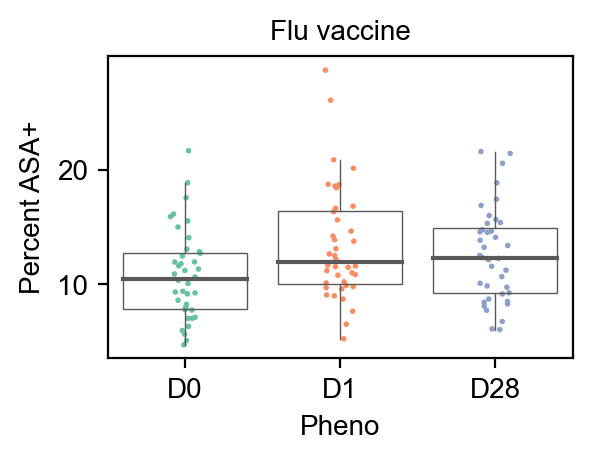

In [123]:
merged = actinfo['Sparks']
ind = (merged['Gating_Simple']!='Treg')
sample_average = (merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index().dropna()
sample_average = sample_average.loc[sample_average['individual'] != 'Control', :]


(fig,ax) = plt.subplots(1,1, figsize=(3, 2), dpi=200)
sp = sns.stripplot(x='Pheno', y='Activation_Status', data=sample_average, dodge=True, ax=ax, palette="Set2", zorder=-1, s=2)

bp = sns.boxplot(x='Pheno', y='Activation_Status', data=sample_average,  dodge=True, fliersize=0, palette="Set2", showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, ax=ax, zorder=5)

ax.set_ylabel('Percent ASA+', fontsize=10)
ax.set_title('Flu vaccine', fontsize=10)

<AxesSubplot:xlabel='Dataset', ylabel='Activation_Status'>

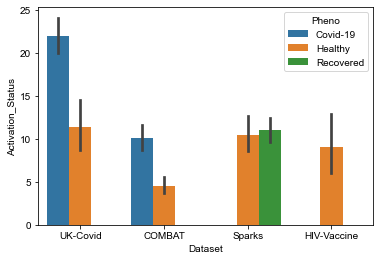

In [148]:
X = actinfo_filt['COMBAT'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
Y = actinfo_filt['UK-Covid'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
Z = actinfo['Sparks'].loc[(actinfo['Sparks']['Pheno']=='D0'), ['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
Z['Pheno'] = Z['individual'].apply(lambda x: x.split('-')[0]).replace({'COVR':'Recovered', 'HC':'Healthy'})
A = actinfo['HIV-Vaccine'].loc[(actinfo['HIV-Vaccine']['Pheno']=='D0'), ['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
A['Pheno'] = 'Healthy'

merged = pd.concat([X, Y, Z, A], axis=0)

ind = (merged['Gating_Simple']!='Treg')


sample_average = (merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index()
sample_average.index = sample_average['individual']
count = merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).count()['Activation_Status'].reset_index()
count.index = count['individual']
sample_average['Ncells'] = count.loc[sample_average.index, 'Activation_Status']
sns.barplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average, order=['UK-Covid', 'COMBAT', 'Sparks', 'HIV-Vaccine'])

Ttest_indResult(statistic=5.9794146576755525, pvalue=1.763297625317448e-07)

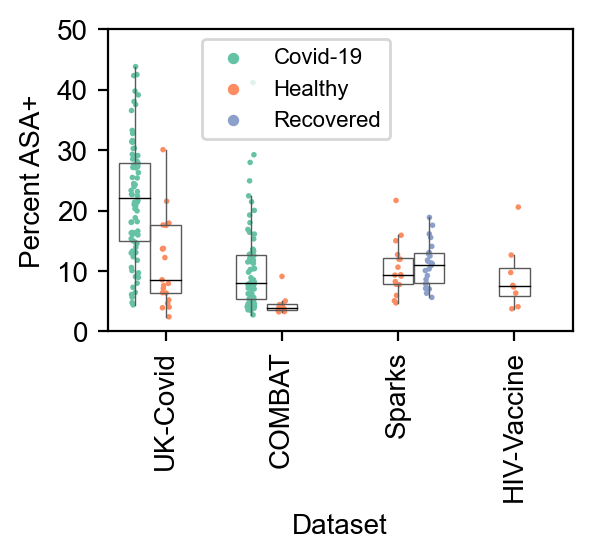

In [152]:
(fig,ax) = plt.subplots(1,1, figsize=(3, 2), dpi=200)

ind = (sample_average['Ncells']>100)

sp = sns.stripplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average.loc[ind, :], dodge=True, ax=ax, palette="Set2", zorder=-1, s=2,
                  order=['UK-Covid', 'COMBAT', 'Sparks', 'HIV-Vaccine'])

bp = sns.boxplot(x='Dataset', y='Activation_Status', data=sample_average, hue='Pheno', dodge=True, fliersize=0, palette="Set2", showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, ax=ax, zorder=5,
                order=['UK-Covid', 'COMBAT', 'Sparks', 'HIV-Vaccine'])
bp.legend_.remove()

handles, labels = sp.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(.18,.6), handles=handles[:3], labels=labels[:3], fontsize=8, markerscale=.4)
ax.set_ylabel('Percent ASA+')
ax.set_ylim([0, 50])
ax.set_xticklabels(['UK-Covid', 'COMBAT', 'Sparks', 'HIV-Vaccine'], rotation=90)

a = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Covid-19'), 'Activation_Status']
b = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Healthy'), 'Activation_Status']
ttest_ind(a,b, equal_var=False)
#ax.text(0, 45, 'P=%.2f'%

<AxesSubplot:xlabel='Pheno', ylabel='Activation_Status'>

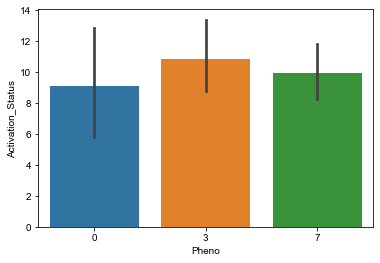

In [283]:
merged = actinfo['HIV-Vaccine'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']].dropna()
sample_average = (merged.groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index().dropna()
sns.barplot(x='Pheno', y='Activation_Status', data=sample_average)

In [285]:
actinfo['HIV-Vaccine']['time']

L1_AAACCCAAGACATACA      7
L1_AAACCCACAACTGGTT      3
L1_AAACCCACAGCATACT      7
L1_AAACCCACATCAGTCA      3
L1_AAACCCATCCACACCT      3
                        ..
E2L8_TTTGGTTTCGTCAACA    0
E2L8_TTTGTTGAGGCATGCA    7
E2L8_TTTGTTGAGTAGAGTT    3
E2L8_TTTGTTGCAGCGTGAA    3
E2L8_TTTGTTGGTCGTGATT    7
Name: time, Length: 73259, dtype: category
Categories (3, object): ['0', '3', '7']

<AxesSubplot:xlabel='group', ylabel='Activation_Status'>

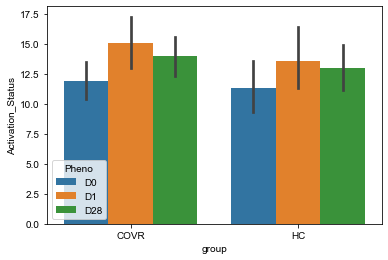

In [264]:
merged = actinfo['Sparks'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset', 'group']].dropna()
sample_average = (merged.groupby(['Dataset', 'Pheno', 'individual', 'group']).mean()*100).reset_index().dropna()
sns.barplot(x='group', hue='Pheno', y='Activation_Status', data=sample_average)

<AxesSubplot:xlabel='group', ylabel='Activation_Status'>

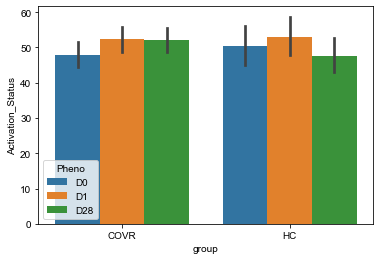

In [266]:
merged = actinfo['Sparks'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset', 'group']].dropna()
sample_average = (merged.loc[merged['Gating_Simple']=='Treg', :].groupby(['Dataset', 'Pheno', 'individual', 'group']).mean()*100).reset_index().dropna()
sns.barplot(x='group', hue='Pheno', y='Activation_Status', data=sample_average)

In [259]:
sample_average

,Dataset,Pheno,individual,Activation_Status,CellCycle_Bin
24,Sparks,Control,Control,0.102371,0.001715
41,Sparks,D0,COVR-2,0.124497,0.002683
42,Sparks,D0,COVR-4,0.148873,0.003694
43,Sparks,D0,COVR-6,0.086614,0.003500
44,Sparks,D0,COVR-8,0.135541,0.003073
...,...,...,...,...,...
159,Sparks,D28,HC-34,0.137694,0.003442
160,Sparks,D28,HC-35,0.094948,0.002508
161,Sparks,D28,HC-37,0.130405,0.002421
162,Sparks,D28,HC-38,0.082228,0.003316


<AxesSubplot:xlabel='Dataset', ylabel='Activation_Status'>

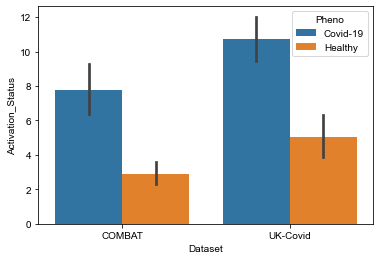

<AxesSubplot:xlabel='Dataset', ylabel='Activation_Status'>

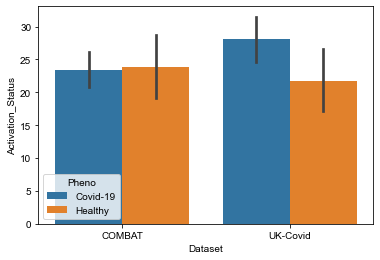

In [181]:
sample_average = (merged.loc[merged['Gating_Simple']=='Treg', :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index()
sns.barplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average)

<AxesSubplot:xlabel='Dataset', ylabel='Activation_Status'>

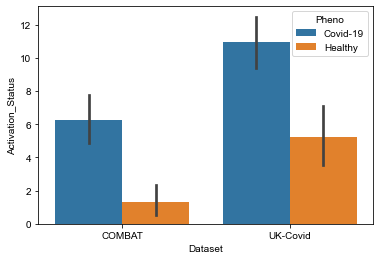

In [184]:
sample_average = (merged.loc[merged['Gating_Simple']=='unconv', :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index()
sns.barplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average)

In [183]:
merged['Gating_Simple'].value_counts()

conv      591397
unconv     67185
Treg       14533
Name: Gating_Simple, dtype: int64

In [182]:
sample_average

,Dataset,Pheno,individual,Activation_Status,CellCycle_Bin
0,COMBAT,Covid-19,G05061,15.447154,0.813008
1,COMBAT,Covid-19,G05064,25.000000,0.694444
2,COMBAT,Covid-19,G05073,4.316547,0.000000
3,COMBAT,Covid-19,G05077,10.810811,2.702703
4,COMBAT,Covid-19,G05078,17.699115,7.964602
...,...,...,...,...,...
182,UK-Covid,Healthy,MH8919283,13.043478,4.347826
183,UK-Covid,Healthy,MH8919332,34.883721,0.000000
184,UK-Covid,Healthy,MH8919333,21.875000,0.000000
185,UK-Covid,Healthy,newcastle65,30.188679,0.000000


In [ ]:
## For individuals with multiple samples, filter the sample with fewer cells
ct = pd.crosstab(activation[individual_col], activation[sample_col])
display((ct>0).sum(axis=1).value_counts())
ind = (ct>0).sum(axis=1)>1
ct = ct.loc[ind, :]
tokeep = ct.loc[:, (ct>0).sum(axis=0)>0].idxmax(axis=1)


tofilt = activation[individual_col].isin(tokeep.index) & ~activation[sample_col].isin(tokeep.values)
activation_filt = activation.loc[~tofilt, :]

ct = pd.crosstab(activation_filt[individual_col], activation_filt[sample_col])
(ct>0).sum(axis=1).value_counts()

In [156]:
actinfo['COMBAT']

,Activation_Score,Activation_Status,individual,sample,Source,TimeSinceOnset,CellCycle_Usage,CellCycle_Bin,Gating,Pheno,Gating_Simple
AAACCTGAGCGGATCA-1-gPlexA1,0.046550,False,S00112,S00112-Ja003,COVID_MILD,12.0,1.054688e-03,False,CD8_EM,Covid-19,conv
AAACCTGCAGCTCGAC-1-gPlexA1,0.013070,False,S00005,S00005-Ja005,COVID_CRIT,14.0,3.612664e-03,False,CD4_CM,Covid-19,conv
AAACCTGCATCTATGG-1-gPlexA1,0.011637,False,H00067,H00067-Ha001,HV,NaN,2.010103e-03,False,CD4_EM,Healthy,conv
AAACCTGGTCTCTCTG-1-gPlexA1,0.020845,False,N00027,N00027-Ja001,Sepsis,9.0,6.916480e-03,False,CD4_CM,NaN,conv
AAACCTGTCACCGGGT-1-gPlexA1,0.055559,False,U00515,U00515-Ua005,COVID_LDN,15.0,1.743664e-03,False,CD8_TEMRA,Covid-19,conv
...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCTCAACC-1-gPlexK7,0.003608,False,S00048,S00048-Ja003,COVID_SEV,12.0,1.342514e-03,False,CD4_Naive,Covid-19,conv
TTTGGTTTCTCGATGA-1-gPlexK7,0.015328,False,N00038,N00038-Ja001,Sepsis,7.0,4.536087e-03,False,CD4_CM,NaN,conv
TTTGTCACACCACGTG-1-gPlexK7,0.003144,False,S00057,S00057-Ja003,COVID_SEV,10.0,7.268757e-05,False,CD8_TEMRA,Covid-19,conv
TTTGTCAGTTACCGAT-1-gPlexK7,0.002599,False,U00501,U00501-Ua005,Flu,11.0,7.784450e-04,False,CD8_EM,NaN,conv


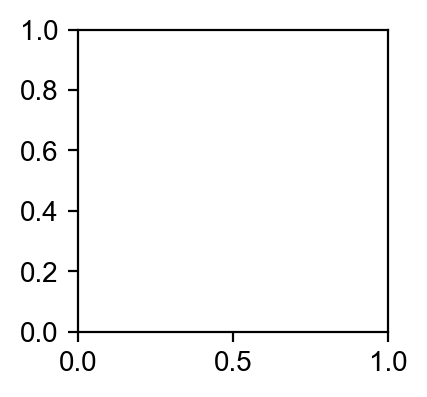

In [154]:
(fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=200)

Only considering the two last: ['.ADTfixed20230831FiltForcNMF', '.h5ad'].
Only considering the two last: ['.ADTfixed20230831FiltForcNMF', '.h5ad'].


In [121]:


activation['Gating_Simple'].value_counts()

conv      374278
unconv     13576
Treg       11745
Name: Gating_Simple, dtype: int64

In [122]:
ct = pd.crosstab([activation['Pheno'], activation['Gating_Simple']], activation['Activation_Status'].astype(str))
covidsum = ct.loc['Covid-19', :].sum().sum()
healthysum = ct.loc['Healthy', :].sum().sum()
ctfrac = ct.loc[:, 'True'].reset_index()
ctfrac.loc[ctfrac['Pheno'] == 'Covid-19', 'True'] /= covidsum
ctfrac.loc[ctfrac['Pheno'] == 'Healthy', 'True'] /= healthysum
ctfrac

,Pheno,Gating_Simple,True
0,Covid-19,Treg,0.007033
1,Covid-19,conv,0.063316
2,Covid-19,unconv,0.001318
3,Healthy,Treg,0.005114
4,Healthy,conv,0.023203
5,Healthy,unconv,0.000395


In [123]:
ct = pd.crosstab(activation['Pheno'], activation['Activation_Status'].astype(str))
ct.div(ct.sum(axis=1), axis=0)

Activation_Status,False,True
Pheno,,
Covid-19,0.928333,0.071667
Healthy,0.971288,0.028712


In [129]:
## For individuals with multiple samples, filter the sample with fewer cells
ct = pd.crosstab(activation[individual_col], activation[sample_col])
display((ct>0).sum(axis=1).value_counts())
ind = (ct>0).sum(axis=1)>1
ct = ct.loc[ind, :]
tokeep = ct.loc[:, (ct>0).sum(axis=0)>0].idxmax(axis=1)


tofilt = activation[individual_col].isin(tokeep.index) & ~activation[sample_col].isin(tokeep.values)
activation_filt = activation.loc[~tofilt, :]

ct = pd.crosstab(activation_filt[individual_col], activation_filt[sample_col])
(ct>0).sum(axis=1).value_counts()

1    109
2     10
3      3
dtype: int64

1    122
dtype: int64

<AxesSubplot:xlabel='Pheno', ylabel='Activation_Status'>

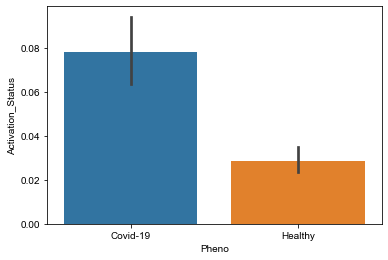

In [143]:
activation_frac = pd.DataFrame(activation_filt.groupby('COMBAT_ID')['Activation_Status'].mean())
ncells = activation_filt.groupby('COMBAT_ID')['Activation_Status'].count()
activation_frac['Ncell'] = ncells.loc[activation_frac.index]

activation_frac = pd.merge(left=activation_frac, right=activation_filt[['COMBAT_ID','COMBAT_participant_timepoint_ID','Source','TimeSinceOnset', 'Pheno']].drop_duplicates(),
         left_index=True, right_on='COMBAT_ID', how='left')

sns.barplot(x='Pheno', y='Activation_Status', data=activation_frac, ci=95)

In [ ]:
activation_frac = pd.DataFrame(activation_filt.groupby('COMBAT_ID')['Activation_Status'].mean())
ncells = activation_filt.groupby('COMBAT_ID')['Activation_Status'].count()
activation_frac['Ncell'] = ncells.loc[activation_frac.index]

activation_frac = pd.merge(left=activation_frac, right=activation_filt[['COMBAT_ID','COMBAT_participant_timepoint_ID','Source','TimeSinceOnset', 'Pheno']].drop_duplicates(),
         left_index=True, right_on='COMBAT_ID', how='left')

sns.barplot(x='Pheno', y='Activation_Status', data=activation_frac, ci=95)

In [145]:
activation_filt['Gating_Simple']

AAACCTGAGCGGATCA-1-gPlexA1    conv
AAACCTGCAGCTCGAC-1-gPlexA1    conv
AAACCTGCATCTATGG-1-gPlexA1    conv
AAACCTGGTCTCTCTG-1-gPlexA1    conv
AAACCTGTCACCGGGT-1-gPlexA1    conv
                              ... 
TTTGGTTTCCTCAACC-1-gPlexK7    conv
TTTGGTTTCTCGATGA-1-gPlexK7    conv
TTTGTCACACCACGTG-1-gPlexK7    conv
TTTGTCAGTTACCGAT-1-gPlexK7    conv
TTTGTCATCCTCTAGC-1-gPlexK7    conv
Name: Gating_Simple, Length: 364949, dtype: object

In [127]:
activation

,Activation_Score,Activation_Status,TCR_clone_ID,COMBAT_ID,COMBAT_participant_timepoint_ID,Source,TimeSinceOnset,CellCycle_Usage,CellCycle_Bin,Gating,Pheno,Gating_Simple
AAACCTGAGCGGATCA-1-gPlexA1,0.046550,False,TRA_CAVGDQTGANNLFF-TRB_CASSLRSGTSYF,S00112,S00112-Ja003,COVID_MILD,12.0,1.054688e-03,False,CD8_EM,Covid-19,conv
AAACCTGCAGCTCGAC-1-gPlexA1,0.013070,False,TRA_CADNFNKFYF-TRB_CASSESPGHSPLHF,S00005,S00005-Ja005,COVID_CRIT,14.0,3.612664e-03,False,CD4_CM,Covid-19,conv
AAACCTGCATCTATGG-1-gPlexA1,0.011637,False,TRA_CAVREAAGNKLTF-TRB_CASSEQGSSYEQYF,H00067,H00067-Ha001,HV,NaN,2.010103e-03,False,CD4_EM,Healthy,conv
AAACCTGGTCTCTCTG-1-gPlexA1,0.020845,False,TRA_CAAIILKAGNNRKLIW-TRB_CASSLPGQISSSYTF,N00027,N00027-Ja001,Sepsis,9.0,6.916480e-03,False,CD4_CM,NaN,conv
AAACCTGTCACCGGGT-1-gPlexA1,0.055559,False,TRA_CAMTPGGGADGLTF-TRB_CASGIGGLGNTEAFF,U00515,U00515-Ua005,COVID_LDN,15.0,1.743664e-03,False,CD8_TEMRA,Covid-19,conv
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCTCAACC-1-gPlexK7,0.003608,False,TRA_CAVDMKVYSGGGADGLTF-TRB_CSAPRLAGGWWETQYF,S00048,S00048-Ja003,COVID_SEV,12.0,1.342514e-03,False,CD4_Naive,Covid-19,conv
TTTGGTTTCTCGATGA-1-gPlexK7,0.015328,False,TRA_CARWAGGFKTIF-TRB_CASSSPGLGDEQFF,N00038,N00038-Ja001,Sepsis,7.0,4.536087e-03,False,CD4_CM,NaN,conv
TTTGTCACACCACGTG-1-gPlexK7,0.003144,False,TRA_CAFEPNSGYALNF-TRB_CASSPETYEQYF,S00057,S00057-Ja003,COVID_SEV,10.0,7.268757e-05,False,CD8_TEMRA,Covid-19,conv
TTTGTCAGTTACCGAT-1-gPlexK7,0.002599,False,TRB_CASSLRVSNQPQHF,U00501,U00501-Ua005,Flu,11.0,7.784450e-04,False,CD8_EM,NaN,conv


In [124]:
cellthresh=100
res = []
for (k,g) in activation.groupby('TimeSinceOnset'):
    for k2, g2, in g.groupby('COMBAT_participant_timepoint_ID'):
        if g2.shape[0]>cellthresh:
            n = g2.shape[0]
            frac = g2['Activation_Status'].mean()
            res.append([k, k2, n, frac])
        
res = pd.DataFrame(res)
res.head()

,0,1,2,3
0,0.0,N00024-Ja001,5667,0.055409
1,0.0,N00028-Ja001,2772,0.064574
2,0.0,N00033-Ja001,3314,0.044659
3,1.0,N00040-Ja001,543,0.071823
4,1.0,U00605-Ua005,232,0.025862


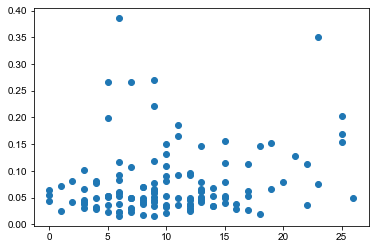

In [125]:
plt.scatter(res[0], res[3])

In [126]:
spearmanr(res[0], res[3])

SpearmanrResult(correlation=0.17229204884879915, pvalue=0.052752006566204414)

# UK-Covid

In [95]:
dataset = 'UK-Covid'
individual_col = params.loc[dataset, 'individual_col']
sample_col = params.loc[dataset, 'sample_col']

In [96]:
count_fn = params.loc[dataset, 'raw_counts_filt_fn']
adata = sc.read(count_fn)

Only considering the two last: ['.ADTfixedADT_70FiltForcNMF', '.h5ad'].
Only considering the two last: ['.ADTfixedADT_70FiltForcNMF', '.h5ad'].


In [104]:
usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')
usage.columns = usage.columns.map(rename_map)
usage_norm = usage.div(usage.sum(axis=1), axis=0)

In [108]:
activation = pd.read_csv(params.loc[dataset, 'activation_score_fn'], index_col = 0, sep = '\t')
activation_score = activation['Activation_Score']
activation['Activation_Status'] = activation['Activation_Score'] > activation_threshold
activation = pd.merge(left=activation, right=adata.obs[[ individual_col, sample_col, 'Status_on_day_collection_summary', 'Days_from_onset']], how='left', left_index=True, right_index=True)
activation['CellCycle_Usage'] = usage_norm.loc[activation.index, cc_geps].sum(axis=1)
activation['CellCycle_Bin'] = activation['CellCycle_Usage']>activation_threshold
gating = pd.read_csv(params.loc[dataset, 'manual_gating_fn'], sep='\t', index_col=0)['0']
activation['Gating'] = gating.loc[activation.index]
activation['Pheno'] = activation[phenomap[dataset]['col']].replace(phenomap[dataset]['mapping'])

In [110]:
convs = ['CD4_Naive', 'CD4_CM', 'CD4_EM', 'CD8_TEMRA', 'CD8_EM', 'CD8_Naive',
       'DP', 'CD8_CM', 'CD4_TEMRA', 'CD4_Memory']
regs = ['Treg']
unconv = ['gdT', 'MAIT', 'DN']
mapping = dict(zip(convs + regs + unconv, ['conv']*len(convs) + ['Treg']*len(regs) + ['unconv']*len(unconv)))

activation['Gating_Simple'] = activation['Gating'].replace(mapping)
activation['Gating_Simple'].value_counts()

conv      217119
unconv     53609
Treg        2788
Name: Gating_Simple, dtype: int64

In [111]:
ct = pd.crosstab([activation['Pheno'], activation['Gating_Simple']], activation['Activation_Status'].astype(str))
covidsum = ct.loc['Covid-19', :].sum().sum()
healthysum = ct.loc['Healthy', :].sum().sum()
ctfrac = ct.loc[:, 'True'].reset_index()
ctfrac.loc[ctfrac['Pheno'] == 'Covid-19', 'True'] /= covidsum
ctfrac.loc[ctfrac['Pheno'] == 'Healthy', 'True'] /= healthysum
ctfrac

,Pheno,Gating_Simple,True
0,Covid-19,Treg,0.003093
1,Covid-19,conv,0.084792
2,Covid-19,unconv,0.023867
3,Healthy,Treg,0.002028
4,Healthy,conv,0.039515
5,Healthy,unconv,0.016429


In [112]:
ct = pd.crosstab(activation['Pheno'], activation['Activation_Status'].astype(str))
ct.div(ct.sum(axis=1), axis=0)

Activation_Status,False,True
Pheno,,
Covid-19,0.888247,0.111753
Healthy,0.942027,0.057973


In [114]:
cellthresh=100
res = []
for (k,g) in activation.groupby('Days_from_onset'):
    for k2, g2, in g.groupby('sample_id'):
        if g2.shape[0]>cellthresh:
            n = g2.shape[0]
            frac = g2['Activation_Status'].mean()
            res.append([k, k2, n, frac])
        
res = pd.DataFrame(res)
res.head()

,0,1,2,3
0,0,BGCV11_CV0058,1402,0.038516
1,1,AP10,2634,0.080106
2,1,MH9143272,4619,0.080970
3,1,MH9143371,941,0.139214
4,1,MH9143425,564,0.129433


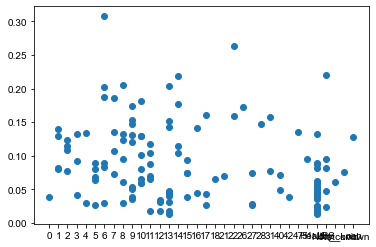

In [115]:
plt.scatter(res[0], res[3])

In [116]:
spearmanr(res[0], res[3])

SpearmanrResult(correlation=-0.12627988013288977, pvalue=0.15064774180585358)